In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import numpy as np
import time
import pickle

In [2]:
os.uname()[1]

'dongwenjian-ThinkPad-E460'

In [2]:
computer_name = os.uname()[1]
if computer_name == "wenjian-desktop":
    img_dir = "/home/wenjian/Internship/data/flickr30kentities/flickr30k-images/"  # For visualization
    
    features_dir = "/home/wenjian/Internship/data/flickr30kentities/flickr30k-feats-otani/bottom-up-feats/"
    #features_dir = "/home/wenjian/Internship/GitHubCloned/DDPN/data/flickr30k/features/bottom-up-feats-resnet101/"

    #train_image_list_filepath = "/home/wenjian/Internship/data/flickr30kentities/Multi30k/task1/image_splits/train.txt"
    #train_triple_filepath = "/home/wenjian/Internship/data/flickr30kentities/queries_extracted/train_queries_fr_1000-images.csv"
    train_triple_filepath = "/home/wenjian/Internship/data/flickr30kentities/queries_extracted/train_queries_fr_3000-images.csv"
    train_triple_filepath_en = "/home/wenjian/Internship/data/flickr30kentities/queries_extracted/train_queries.csv"

    val_triple_filepath = "/home/wenjian/Internship/data/flickr30kentities/queries_extracted/val_queries_fr.csv"
    test_triple_filepath = "/home/wenjian/Internship/data/flickr30kentities/queries_extracted/test_2016_flickr_queries_fr.csv"
    
    xml_dirpath = "/home/wenjian/Internship/data/flickr30kentities/annotations/Annotations/"

    project_root = "/home/wenjian/Internship/DDPN_transfer/"
    
    english_pretrained_model_path = "/home/wenjian/Internship/DDPN_transfer/pretrained-models/2019-08-07_10-36-3_rank-loss-only_adam-beta2-0.999_dropout-batchnorm-later_checkpoint_9_67.76.tar"
    specific_dictionary_file = "/home/wenjian/Internship/data/word_allignment/lex.e2f"  # The file name is e2f, but in fact it is f2e
    general_dictionary_file = "/home/wenjian/Internship/DDPN_transfer/dictionary/Fr-En-GoogleTrans_dictionary.txt"
    

elif computer_name == "apas":
    img_dir = "/home/wenjian/data/flickr30kentities/flickr30k-images/"  # For visualization
    
    features_dir = "/home/wenjian/data/flickr30kentities/bottom-up-feats/"
    
    #train_image_list_filepath = "/home/wenjian/data/flickr30kentities/Multi30k/task1/image_splits/train.txt"
    train_triple_filepath = "/home/wenjian/data/flickr30kentities/queries_extracted/train_queries.csv"

    val_triple_filepath = "/home/wenjian/data/flickr30kentities/queries_extracted/val_queries.csv"
    
    test_triple_filepath = "/home/wenjian/data/flickr30kentities/queries_extracted/test_2016_flickr_queries.csv"

    xml_dirpath = "/home/wenjian/data/flickr30kentities/annotations/Annotations/"

    project_root = "/home/wenjian/code/"
    
    pretrained_model_path = None

elif computer_name == "dongwenjian-ThinkPad-E460":
    fr_dataset_volume = "3k"
    
    features_dir = "/media/dongwenjian/SSDBACKUP/Internship/data/flickr30kentities/flickr30k-feats-otani/bottom-up-feats/"
    
    #train_image_list_filepath = "/home/wenjian/data/flickr30kentities/Multi30k/task1/image_splits/train.txt"
    train_triple_filepath = "/media/dongwenjian/SSDBACKUP/Internship/data/flickr30kentities/queries_extracted/train_queries.csv"

    val_triple_filepath = "/media/dongwenjian/SSDBACKUP/Internship/data/flickr30kentities/queries_extracted/val_queries.csv"
    
    test_triple_filepath = "/media/dongwenjian/SSDBACKUP/Internship/data/flickr30kentities/queries_extracted/test_2016_flickr_queries.csv"

    xml_dirpath = "/media/dongwenjian/SSDBACKUP/Internship/data/flickr30kentities/annotations/Annotations/"

    project_root = "/media/dongwenjian/SSDBACKUP/newly_added/new_experiments/word2word_test_set/"
    
    pretrained_model_path = "/media/dongwenjian/SSDBACKUP/Internship/DDPN_transfer/pretrained-models/2019-08-17_19-26-48_L1-gt-softlabel_drop0.5_checkpoint_4_69.30.tar"
    
else:
    raise Exception("Failed to initialize paths: computer not recognized")
print(computer_name)

dongwenjian-ThinkPad-E460


In [3]:
# For testing the following idea:
# French test set translated into English by Google Translate, then run with English model
# On apas:
#test_triple_filepath = "/home/wenjian/data/flickr30kentities/queries_extracted/test_2016_flickr_queries_fr_translated_into_en.csv"

In [3]:
# For testing the following idea:
# French test set translated into English by word2word manner, then run with English model
# On dongwenjian-ThinkPad-E460
test_triple_filepath = "/media/dongwenjian/SSDBACKUP/newly_added/new_experiments/test-set_word2word_translation/test_2016_flickr_queries_fr_word2word_into_en.csv"
    

In [5]:
torch.cuda.device_count()

0

In [4]:
device = torch.device("cuda:5" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")


In [5]:
class CFG:
    def __init__(self):
        # cfg_path for future use
        self.xml_dirpath = xml_dirpath
        self.triple_filepaths = {'train': train_triple_filepath,
                                 'val': val_triple_filepath,
                                 'test': test_triple_filepath
                                }
        self.RPN_TOPN = 100
        
        # Configure for network
        self.WORD_EMB_SIZE = 300
        self.RNN_DIM = 1024
        self.VISUAL_FEATURES = 2048  # For resnet
        self.SPATIAL_FEATURES = 5
        self.SOFTLABEL_THRESHOLD = 0.5 # 0.5 in paper
        self.GAMMA = 1
        self.DELTA = 1
        self.STEMMING = False
        self.epsilon = 1e-7
        self.dropout_rate = 0.5
        self.lr_decay_rate = 0.7
        self.initial_lr = 0.001
        self.use_pretrained_word_embedding = None  # candidate: None, "GloVe"
        self.use_pretrained_model = False
        self.regression_loss = False
        
cfg = CFG()

In [7]:
import sys
sys.version

'3.6.8 |Anaconda, Inc.| (default, Dec 30 2018, 01:22:34) \n[GCC 7.3.0]'

In [7]:

# train_imageID_list = []
# with open(train_image_list_filepath, 'r') as f:
#     l = f.readline()
#     while l :
#         train_imageID_list.append(l.split('.')[0])
#         l = f.readline()
# print(len(train_imageID_list))
# print(train_imageID_list[0])

## Establish vocabulary dictionary from training set    

In [6]:
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
import gensim
import pandas as pd

In [7]:
train_df = pd.read_csv(train_triple_filepath)

In [8]:
stemmer = SnowballStemmer("english")
corpus_list = train_df["entity_content"].values.tolist()
corpus_list = ['EMPTYWORDTOKEN', 'UNKNOWNWORD'] + corpus_list  # 'EMPTYWORDTOKEN' is the token for empty word. It is needed because the input data for word embedding layer require padding. 
corpus_list

['EMPTYWORDTOKEN',
 'UNKNOWNWORD',
 'Two young guys',
 'shaggy hair',
 'their hands',
 'Two young , White males',
 'many bushes',
 'Two men',
 'green shirts',
 'A man',
 'a blue shirt',
 'Two friends',
 'Several men',
 'hard hats',
 'a giant pulley system',
 'Workers',
 'a piece of equipment',
 'Two men',
 'a machine',
 'hard hats',
 'Four men',
 'a tall structure',
 'Three men',
 'a large rig',
 'A child',
 'a pink dress',
 'a set of stairs',
 'an entry way',
 'A little girl',
 'a pink dress',
 'A little girl',
 'the stairs',
 'her playhouse',
 'A little girl',
 'a wooden playhouse',
 'A girl',
 'Someone',
 'a blue shirt',
 'hat',
 'stair',
 'a window',
 'A man',
 'a blue shirt',
 'a ladder',
 'a window',
 'A man',
 'a ladder',
 'the window of a tall building',
 'man',
 'blue shirt',
 'jeans',
 'ladder',
 'windows',
 'a man',
 'a ladder',
 'a window',
 'Two men',
 'one',
 'a gray shirt',
 'one',
 'a black shirt',
 'a stove',
 'Two guy',
 'Two men',
 'food',
 'a stove',
 'Two men',
 't

In [9]:
if cfg.STEMMING:
    corpus = [[stemmer.stem(w) for w in word_tokenize(q)] for q in corpus_list]
else: 
    corpus = [[w.lower() for w in word_tokenize(q)] for q in corpus_list]
# corpus is a list of list of string

In [10]:
len(corpus)

413629

In [11]:
corpus[0]

['emptywordtoken']

In [12]:
corpus[1]

['unknownword']

In [10]:
training_corpus_dct = gensim.corpora.Dictionary(corpus)

In [14]:
training_corpus_dct.__dict__

{'token2id': {'emptywordtoken': 0,
  'unknownword': 1,
  'guys': 2,
  'two': 3,
  'young': 4,
  'hair': 5,
  'shaggy': 6,
  'hands': 7,
  'their': 8,
  ',': 9,
  'males': 10,
  'white': 11,
  'bushes': 12,
  'many': 13,
  'men': 14,
  'green': 15,
  'shirts': 16,
  'a': 17,
  'man': 18,
  'blue': 19,
  'shirt': 20,
  'friends': 21,
  'several': 22,
  'hard': 23,
  'hats': 24,
  'giant': 25,
  'pulley': 26,
  'system': 27,
  'workers': 28,
  'equipment': 29,
  'of': 30,
  'piece': 31,
  'machine': 32,
  'four': 33,
  'structure': 34,
  'tall': 35,
  'three': 36,
  'large': 37,
  'rig': 38,
  'child': 39,
  'dress': 40,
  'pink': 41,
  'set': 42,
  'stairs': 43,
  'an': 44,
  'entry': 45,
  'way': 46,
  'girl': 47,
  'little': 48,
  'the': 49,
  'her': 50,
  'playhouse': 51,
  'wooden': 52,
  'someone': 53,
  'hat': 54,
  'stair': 55,
  'window': 56,
  'ladder': 57,
  'building': 58,
  'jeans': 59,
  'windows': 60,
  'one': 61,
  'gray': 62,
  'black': 63,
  'stove': 64,
  'guy': 65,
  '

In [15]:
len(training_corpus_dct.token2id)

14384

In [19]:
training_corpus_dct.__dir__()

['token2id',
 'id2token',
 'dfs',
 'num_docs',
 'num_pos',
 'num_nnz',
 '__module__',
 '__doc__',
 '__init__',
 '__getitem__',
 '__iter__',
 'iterkeys',
 'iteritems',
 'itervalues',
 'keys',
 '__len__',
 '__str__',
 'from_documents',
 'add_documents',
 'doc2bow',
 'doc2idx',
 'filter_extremes',
 'filter_n_most_frequent',
 'filter_tokens',
 'compactify',
 'save_as_text',
 'merge_with',
 'patch_with_special_tokens',
 'load_from_text',
 'from_corpus',
 '__abstractmethods__',
 '_abc_registry',
 '_abc_cache',
 '_abc_negative_cache',
 '_abc_negative_cache_version',
 'load',
 '_load_specials',
 '_adapt_by_suffix',
 '_smart_save',
 '_save_specials',
 'save',
 '__dict__',
 '__weakref__',
 '__repr__',
 '__hash__',
 '__getattribute__',
 '__setattr__',
 '__delattr__',
 '__lt__',
 '__le__',
 '__eq__',
 '__ne__',
 '__gt__',
 '__ge__',
 '__new__',
 '__reduce_ex__',
 '__reduce__',
 '__subclasshook__',
 '__init_subclass__',
 '__format__',
 '__sizeof__',
 '__dir__',
 '__class__',
 '__slots__',
 'get',
 

In [20]:
training_corpus_dct.dfs

{0: 1,
 1: 1,
 3: 19353,
 4: 11942,
 2: 601,
 6: 45,
 5: 1995,
 8: 2776,
 7: 1330,
 9: 1322,
 11: 11620,
 10: 233,
 13: 1110,
 12: 81,
 14: 8629,
 15: 4470,
 16: 839,
 17: 214432,
 18: 38854,
 19: 10014,
 20: 11839,
 21: 364,
 22: 1881,
 23: 449,
 24: 763,
 25: 184,
 26: 18,
 27: 23,
 28: 1015,
 31: 643,
 30: 20460,
 29: 402,
 32: 483,
 33: 1972,
 35: 381,
 34: 296,
 36: 5163,
 37: 3988,
 38: 9,
 39: 4557,
 41: 2555,
 40: 1963,
 42: 224,
 43: 401,
 44: 11746,
 45: 8,
 46: 40,
 48: 4230,
 47: 8601,
 49: 34427,
 50: 4901,
 51: 16,
 52: 887,
 53: 626,
 54: 3645,
 55: 27,
 56: 853,
 57: 298,
 58: 2436,
 59: 1741,
 60: 158,
 61: 5034,
 62: 1876,
 63: 11030,
 64: 83,
 65: 1332,
 66: 1363,
 67: 202,
 68: 15591,
 69: 1816,
 70: 2305,
 71: 8939,
 73: 1026,
 72: 490,
 75: 2315,
 74: 1415,
 76: 1192,
 77: 1787,
 78: 937,
 81: 177,
 79: 254,
 80: 40,
 82: 2,
 83: 2,
 84: 951,
 85: 52,
 86: 679,
 88: 152,
 87: 352,
 89: 9,
 90: 4224,
 91: 438,
 92: 64,
 93: 15,
 94: 506,
 95: 16,
 96: 20165,
 97: 1

In [21]:
freq = list(training_corpus_dct.dfs.values())
print(freq)

[1, 1, 19353, 11942, 601, 45, 1995, 2776, 1330, 1322, 11620, 233, 1110, 81, 8629, 4470, 839, 214432, 38854, 10014, 11839, 364, 1881, 449, 763, 184, 18, 23, 1015, 643, 20460, 402, 483, 1972, 381, 296, 5163, 3988, 9, 4557, 2555, 1963, 224, 401, 11746, 8, 40, 4230, 8601, 34427, 4901, 16, 887, 626, 3645, 27, 853, 298, 2436, 1741, 158, 5034, 1876, 11030, 83, 1332, 1363, 202, 15591, 1816, 2305, 8939, 1026, 490, 2315, 1415, 1192, 1787, 937, 177, 254, 40, 2, 2, 951, 52, 679, 152, 352, 9, 4224, 438, 64, 15, 506, 16, 20165, 1961, 1192, 253, 119, 34, 573, 276, 22, 261, 272, 128, 238, 35, 24, 123, 251, 788, 51, 195, 2291, 248, 123, 105, 1564, 67, 31, 253, 550, 1935, 120, 41, 189, 8099, 3951, 27, 10, 1166, 2080, 231, 4, 128, 44, 99, 346, 674, 107, 29, 25, 16, 129, 118, 2, 25, 2, 897, 2745, 1025, 208, 103, 23, 2529, 4853, 361, 7095, 1061, 1483, 16, 247, 3, 1870, 4, 5, 2, 3, 3043, 53, 72, 78, 3140, 1720, 2, 56, 87, 238, 152, 255, 59, 204, 1547, 5318, 193, 475, 665, 573, 448, 71, 133, 215, 462, 233, 1

In [22]:
torch.sum(torch.tensor(freq) >= 3)

tensor(6709)

In [23]:
torch.sum(torch.tensor(freq) >= 5)

tensor(4990)

## Dataset statistics

In [35]:
# For English
general_df = pd.read_csv(test_triple_filepath)
corpus_list_en = general_df["entity_content"].values.tolist() 
corpus_list_en

['The man',
 'pierced ears',
 'glasses',
 'an orange hat',
 'A man',
 'glasses',
 'a beer can crocheted hat',
 'A man',
 'gauges',
 'glasses',
 'a Blitz hat',
 'A man',
 'an orange hat',
 'A man',
 'an orange hat',
 'glasses',
 'A black and white dog',
 'a grassy garden',
 'a white fence',
 'A Boston Terrier',
 'lush green grass',
 'a white fence',
 'A black and white dog',
 'the grass',
 'A dog',
 'the green grass',
 'a wooden fence',
 'A Boston terrier',
 'the grass',
 'A young female student',
 'a board',
 'her Karate instructor',
 'Girl',
 'a piece of wood',
 'karate instructor',
 'A girl',
 'a stick',
 'a man',
 'A girl',
 'karate uniform',
 'a stick',
 'A girl',
 'boards',
 'Five snowmobile riders',
 'all',
 'helmets',
 'goggles',
 'a snowy clearing',
 'a forest',
 'their snowmobiles',
 'black snow pants',
 'a black coat',
 'white coat',
 'red coat',
 'blue coat',
 'black coat',
 'Five people',
 'winter jackets',
 'helmets',
 'the snow',
 'snowmobiles',
 'Five people',
 'winter c

In [36]:
corpus_en = [[w.lower() for w in word_tokenize(q)] for q in corpus_list_en]
general_corpus_dct_en = gensim.corpora.Dictionary(corpus_en)

In [37]:
len(corpus_en)

14476

In [38]:
len(general_corpus_dct_en.token2id)

2758

In [39]:
freq = list(general_corpus_dct_en.dfs.values())
torch.sum(torch.tensor(freq) >= 3)

tensor(1026)

## GloVe Word embedding

In [10]:
import torchtext
import pandas as pd
from nltk.tokenize import word_tokenize

In [11]:
glove = torchtext.vocab.GloVe(name='6B', dim=300)

Noted that in GloVe, there is no unknown word token, nor empty word token. 
Here we use index=1, which is '.' as empty word token

In [12]:
train_df = pd.read_csv("/home/wenjian/Internship/data/flickr30kentities/queries_extracted/train_queries.csv")

In [13]:
corpus_list = train_df["entity_content"].values.tolist()

In [14]:
if cfg.STEMMING:
    from nltk.stem.snowball import SnowballStemmer
    stemmer = SnowballStemmer("english")
    corpus = [[stemmer.stem(w) for w in word_tokenize(q)] for q in corpus_list]
else: 
    corpus = [[w.lower() for w in word_tokenize(q)] for q in corpus_list]

In [15]:
corpus

[['two', 'young', 'guys'],
 ['shaggy', 'hair'],
 ['their', 'hands'],
 ['two', 'young', ',', 'white', 'males'],
 ['many', 'bushes'],
 ['two', 'men'],
 ['green', 'shirts'],
 ['a', 'man'],
 ['a', 'blue', 'shirt'],
 ['two', 'friends'],
 ['several', 'men'],
 ['hard', 'hats'],
 ['a', 'giant', 'pulley', 'system'],
 ['workers'],
 ['a', 'piece', 'of', 'equipment'],
 ['two', 'men'],
 ['a', 'machine'],
 ['hard', 'hats'],
 ['four', 'men'],
 ['a', 'tall', 'structure'],
 ['three', 'men'],
 ['a', 'large', 'rig'],
 ['a', 'child'],
 ['a', 'pink', 'dress'],
 ['a', 'set', 'of', 'stairs'],
 ['an', 'entry', 'way'],
 ['a', 'little', 'girl'],
 ['a', 'pink', 'dress'],
 ['a', 'little', 'girl'],
 ['the', 'stairs'],
 ['her', 'playhouse'],
 ['a', 'little', 'girl'],
 ['a', 'wooden', 'playhouse'],
 ['a', 'girl'],
 ['someone'],
 ['a', 'blue', 'shirt'],
 ['hat'],
 ['stair'],
 ['a', 'window'],
 ['a', 'man'],
 ['a', 'blue', 'shirt'],
 ['a', 'ladder'],
 ['a', 'window'],
 ['a', 'man'],
 ['a', 'ladder'],
 ['the', 'window'

## Data Generation

In [11]:
from torch.utils import data
import pandas as pd
import xml.etree.ElementTree as ET
# https://stanford.edu/~shervine/blog/pytorch-how-to-generate-data-parallel
class DDPNDataset(data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, cfg, phase):
        'Initialization'
        #self.labels = labels
        #self.list_IDs = list_IDs
        self.cfg = cfg
        self.phase = phase
        self.df_triple = pd.read_csv(self.cfg.triple_filepaths[self.phase])  # Triple means (image, ground_truth_bounding_box, query)
        

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.df_triple.index)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        imageID = str(self.df_triple.iloc[index]["imgId"])
        entityID = str(self.df_triple.iloc[index]["entityId"])
        
        # Load data and get label
        # X = torch.load('data/' + ID + '.pt')
        # X should be all the inputs, include visual features and text query
        zf = np.load(features_dir+imageID+'.jpg.npz')
        num_bbox = zf['num_bbox']
        visual_feat = zf['x']  # visual_feat's shape here is supposed to be (2048, num_bbox) for resnet, (4096, num_bbox) for vgg16
        visual_feat = np.transpose(visual_feat) # now (num_bbox, 2048) for resnet, (num_bbox, 4096) for vgg16
        spatial_feat = zf['bbox'] # spatial_feat's shape here is supposed to be (num_bbox, 4)
        x1 = spatial_feat[:,0]
        y1 = spatial_feat[:,1]
        x2 = spatial_feat[:,2]
        y2 = spatial_feat[:,3]
        image_w = zf['image_w']
        image_h = zf['image_h']
        spatial_feat = np.column_stack((x1/image_w, y1/image_h, x2/image_w, y2/image_h, (x2-x1)*(y2-y1)/(image_w*image_h)))
        
        # Concatenate visual features and spatial features
        X = np.column_stack((visual_feat, spatial_feat))
        
        # If there are fewer than self.cfg.RPN_TOPN=100 proposals, add 0 rows below
        for i in range(X.shape[0], self.cfg.RPN_TOPN):
            zero_row = np.zeros((1,X.shape[1]))
            X = np.vstack((X, zero_row))
        # Convert numpy array to torch tensor 
        X = torch.from_numpy(X)
        X = X.float()
        
        query = self.df_triple.iloc[index]["entity_content"]
        
        # Get ground truth bounding box
        gt_bbox = self._get_bounding_box(imageID, entityID) # gt_bbox is a triple in format (x1, y1, x2, y2)
        # Get the bounding box boundary regard as image size
        gt_bbox[0] /= float(image_w)
        gt_bbox[2] /= float(image_w)
        gt_bbox[1] /= float(image_h)
        gt_bbox[3] /= float(image_h)
        # Convert list to torch tensor
        gt_bbox = torch.tensor(gt_bbox) 
        
        additional_info = (imageID, entityID, image_w, image_h) # those info are not directly used in training, but used in visualization

        return (X, query), gt_bbox, additional_info  
    
    def _get_bounding_box(self, image_id, object_id): # image_id and object_id are expected to be string
         
        xml_tree = ET.parse(self.cfg.xml_dirpath + image_id + '.xml')
        root = xml_tree.getroot()
        boxes = []  # To deal with one object, multiple bounding boxes
        for obj in root.findall('object'):
            for name in obj.findall('name'):
                if name.text == object_id:
                    bndbox = obj.find("bndbox")
                    x1 = int(bndbox.find("xmin").text)
                    y1 = int(bndbox.find("ymin").text)
                    x2 = int(bndbox.find("xmax").text)
                    y2 = int(bndbox.find("ymax").text)
                    
                    boxes.append([x1, y1, x2, y2])
        if len(boxes)==0:
            raise Exception("Entity not found. Image id: "+image_id+", Entity id: "+object_id)
        boxes_array = np.array(boxes)
        # When there are multiple bounding boxes, draw the minimum box which contains all these invidual boxes
        x1 = np.min(boxes_array[:,0])
        y1 = np.min(boxes_array[:,1])
        x2 = np.max(boxes_array[:,2])
        y2 = np.max(boxes_array[:,3])
                    
        return [x1, y1, x2, y2]        

In [24]:
# For testing 
def _get_bounding_box(image_id, object_id): # image_id and object_id are expected to be string
    xml_dirpath = "/home/wenjian/Internship/data/flickr30kentities/annotations/Annotations/"

    xml_tree = ET.parse(xml_dirpath + image_id + '.xml')
    root = xml_tree.getroot()
    boxes = []
    for obj in root.findall('object'):
        #for name in obj:
        for name in obj.findall('name'):
            print(name)
            if name.text == object_id:
                bndbox = obj.find("bndbox")
                x1 = int(bndbox.find("xmin").text)
                y1 = int(bndbox.find("ymin").text)
                x2 = int(bndbox.find("xmax").text)
                y2 = int(bndbox.find("ymax").text)

                boxes.append([x1, y1, x2, y2])
    if len(boxes)==0:
        raise Exception("Entity not found. Image id: "+image_id+", Entity id: "+object_id)
    boxes_array = np.array(boxes)

    x1 = np.min(boxes_array[:,0])
    y1 = np.min(boxes_array[:,1])
    x2 = np.max(boxes_array[:,2])
    y2 = np.max(boxes_array[:,3])

    return [x1, y1, x2, y2] 

print(_get_bounding_box(str(36979), str(137644)))  # Expected result: [2, 40, 500, 373]
print(_get_bounding_box(str(1000092795), str(1))

SyntaxError: invalid syntax (<ipython-input-24-801709dedfb8>, line 32)

In [12]:
training_set = DDPNDataset(cfg, 'train')
validation_set = DDPNDataset(cfg, 'val')
test_set = DDPNDataset(cfg, 'test')

In [26]:
len(training_set)

413627

In [27]:
# There are 413627 triples in the training set

training_set[0]

((tensor([[2.9460, 0.0000, 0.0000,  ..., 0.9983, 0.9990, 0.1519],
          [0.0000, 0.0000, 0.3983,  ..., 0.4634, 0.7727, 0.1531],
          [2.3487, 0.0337, 0.0208,  ..., 0.7677, 0.4751, 0.0328],
          ...,
          [0.7473, 0.0938, 0.4703,  ..., 0.8276, 0.7052, 0.0970],
          [0.0000, 0.0000, 0.1383,  ..., 0.5049, 0.5820, 0.2939],
          [0.0274, 1.5578, 0.0000,  ..., 0.6135, 0.9990, 0.2173]]),
  'Two young guys'),
 tensor([0.4775, 0.2200, 0.7838, 0.7460]),
 ('1000092795', '1', array(333), array(500)))

In [28]:
training_set[0][0]

(tensor([[2.9460, 0.0000, 0.0000,  ..., 0.9983, 0.9990, 0.1519],
         [0.0000, 0.0000, 0.3983,  ..., 0.4634, 0.7727, 0.1531],
         [2.3487, 0.0337, 0.0208,  ..., 0.7677, 0.4751, 0.0328],
         ...,
         [0.7473, 0.0938, 0.4703,  ..., 0.8276, 0.7052, 0.0970],
         [0.0000, 0.0000, 0.1383,  ..., 0.5049, 0.5820, 0.2939],
         [0.0274, 1.5578, 0.0000,  ..., 0.6135, 0.9990, 0.2173]]),
 'Two young guys')

In [29]:
A, b = training_set[0][0]

In [30]:
A

tensor([[2.9460, 0.0000, 0.0000,  ..., 0.9983, 0.9990, 0.1519],
        [0.0000, 0.0000, 0.3983,  ..., 0.4634, 0.7727, 0.1531],
        [2.3487, 0.0337, 0.0208,  ..., 0.7677, 0.4751, 0.0328],
        ...,
        [0.7473, 0.0938, 0.4703,  ..., 0.8276, 0.7052, 0.0970],
        [0.0000, 0.0000, 0.1383,  ..., 0.5049, 0.5820, 0.2939],
        [0.0274, 1.5578, 0.0000,  ..., 0.6135, 0.9990, 0.2173]])

In [31]:
A.size()

torch.Size([100, 2053])

In [32]:
(A[0][-3] - A[0][-5])*(A[0][-2] - A[0][-4])

tensor(0.1519)

In [33]:
b

'Two young guys'

In [34]:
training_set[0][0][0].shape

torch.Size([100, 2053])

In [35]:
len(validation_set)

14526

In [36]:
# There are 14527 triples in the validation set

validation_set[0]

((tensor([[1.1333e-01, 2.3880e+00, 8.1123e-01,  ..., 9.9900e-01, 5.7636e-01,
           5.1638e-01],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 8.3661e-01, 9.9833e-01,
           9.5590e-03],
          [9.6640e-04, 3.0147e-01, 1.2200e+00,  ..., 8.3006e-01, 8.5222e-01,
           1.6638e-01],
          ...,
          [2.0308e-01, 1.5471e-03, 0.0000e+00,  ..., 7.2942e-01, 4.9238e-01,
           2.1457e-02],
          [0.0000e+00, 1.6355e-01, 8.3413e-02,  ..., 9.9900e-01, 9.9833e-01,
           1.1927e-01],
          [0.0000e+00, 4.9662e-02, 2.4938e-02,  ..., 2.7541e-01, 1.6554e-01,
           1.7283e-03]]), 'A group of people'),
 tensor([0.1720, 0.1081, 0.4280, 0.3213]),
 ('1018148011', '568', array(500), array(333)))

In [37]:
validation_set[0][0][0].shape

torch.Size([100, 2053])

In [38]:
len(training_generator)

NameError: name 'training_generator' is not defined

In [58]:
413627/64

6462.921875

In [29]:
len(test_set)

14476

In [47]:
test_set[0]

((tensor([[0.0000, 0.0000, 0.2207,  ..., 0.8460, 0.4874, 0.2967],
          [0.0000, 0.0532, 0.0260,  ..., 0.4820, 0.5275, 0.0117],
          [0.0020, 0.0000, 0.0000,  ..., 0.7766, 0.9983, 0.4192],
          ...,
          [0.0022, 0.0000, 0.0347,  ..., 0.7141, 0.9983, 0.1812],
          [0.0439, 0.0399, 0.0406,  ..., 0.8497, 0.7945, 0.6751],
          [0.0152, 0.7325, 0.0020,  ..., 0.3951, 0.9826, 0.1539]]), 'The man'),
 tensor([0.1100, 0.0911, 0.7980, 1.0000]),
 ('1007129816', '203', array(500), array(461)))

In [18]:
# Under the test for: French test set translated into English by word2word manner, then run with English model
len(test_set)

2789

In [28]:
test_set[9]

((tensor([[0.4419, 0.0000, 0.1148,  ..., 0.5628, 0.2294, 0.0109],
          [0.3927, 0.0000, 0.5165,  ..., 0.3359, 0.3034, 0.0075],
          [0.0070, 0.0000, 0.0393,  ..., 0.1289, 0.2388, 0.0059],
          ...,
          [0.0231, 0.0000, 0.3389,  ..., 0.9987, 0.8358, 0.2231],
          [0.2098, 0.0000, 0.0756,  ..., 0.9114, 0.9983, 0.3332],
          [0.0000, 0.0854, 0.0000,  ..., 0.9987, 0.9983, 0.3263]]),
  "the jackets d' hiver"),
 tensor([0.0140, 0.2027, 1.0000, 0.6987]),
 ('102617084', '749', array(500), array(375)))

### Calculate IoU score between two boxes

In [13]:
def intersect(box_a, box_b):  # Tackle with N (like 100) box pairs at the same time
    #print(box_a.type())
    #print(box_b.type())
    inter_xmin=torch.max(box_a[:,:,0], box_b[:,:,0])
    inter_xmax=torch.min(box_a[:,:,2], box_b[:,:,2])
    inter_ymin=torch.max(box_a[:,:,1], box_b[:,:,1])
    inter_ymax=torch.min(box_a[:,:,3], box_b[:,:,3])
    inter = torch.max((inter_xmax-inter_xmin).float(), torch.tensor(0).float().to(box_a.device)) * torch.max((inter_ymax-inter_ymin).float(), torch.tensor(0).float().to(box_a.device))
    return inter

In [30]:
b1 = torch.tensor([[1,5,4,8],[1,1,3,3],[3,6,6,9],[2,3,5,5],[1,2,3,4]]).to(device)
b2 = torch.tensor([[3,2,7,6],[5,5,8,8],[1,3,4,7],[1,2,6,6],[4,1,6,3]]).to(device)
b1 = b1.unsqueeze(0)
b2 = b2.unsqueeze(0)
print(intersect(b1,b2)) # intersection expected: 1, 0, 1, 6, 0

tensor([[1., 0., 1., 6., 0.]])


In [14]:
# https://github.com/amdegroot/ssd.pytorch/blob/master/layers/box_utils.py#L48
def IoU(box_a, box_b):  # Tackle with N (like 100) box pairs at the same time
    # The shape of each input: (batch_size, box_number_in_each_image, 4)
    box_a = box_a.float() 
    box_b = box_b.float()
    #print("box_a shape", box_a.size())
    #print("box_b shape", box_b.size())
    inter = intersect(box_a, box_b)
    area_a = (box_a[:,:,2] - box_a[:,:,0]) * (box_a[:,:,3] - box_a[:,:,1])
    area_b = (box_b[:,:,2] - box_b[:,:,0]) * (box_b[:,:,3] - box_b[:,:,1])
    union = area_a + area_b - inter
    return inter.float() / union.float()

In [32]:
print(IoU(b1,b2))  # Expected answer: tensor([[0.0417, 0.0000, 0.0500, 0.3000, 0.0000]])

tensor([[0.0417, 0.0000, 0.0500, 0.3000, 0.0000]])


### Calculate softlable

In [41]:
training_set[374573][0][0][:,-5:-1]

tensor([[5.1969e-04, 4.4159e-02, 7.1317e-01, 9.4961e-01],
        [0.0000e+00, 6.2040e-02, 4.7278e-01, 9.3002e-01],
        [0.0000e+00, 5.4799e-01, 9.8721e-01, 9.9219e-01],
        [0.0000e+00, 1.2673e-01, 3.8553e-01, 5.9441e-01],
        [2.3631e-01, 4.3101e-02, 7.0622e-01, 7.7726e-01],
        [1.2156e-01, 2.3790e-01, 7.8092e-01, 8.9407e-01],
        [2.0145e-01, 6.4568e-02, 6.4798e-01, 4.8737e-01],
        [2.2413e-01, 7.5099e-02, 9.8721e-01, 5.4597e-01],
        [9.2835e-02, 5.8494e-01, 6.3375e-01, 9.1759e-01],
        [0.0000e+00, 1.5378e-01, 5.7126e-01, 5.7386e-01],
        [0.0000e+00, 0.0000e+00, 3.2736e-01, 2.6507e-01],
        [7.6301e-01, 5.2890e-01, 9.8721e-01, 9.9219e-01],
        [0.0000e+00, 2.8935e-01, 6.5871e-01, 7.9631e-01],
        [0.0000e+00, 0.0000e+00, 9.8721e-01, 5.5247e-01],
        [0.0000e+00, 3.1430e-02, 5.3487e-01, 4.0054e-01],
        [1.0286e-01, 7.0030e-01, 6.0901e-01, 9.4653e-01],
        [0.0000e+00, 3.1606e-01, 9.8721e-01, 9.9219e-01],
        [2.857

In [82]:
i = 374573
IoU(training_set[i][0][0][:,-5:-1].unsqueeze(0), training_set[i][1].repeat((1,cfg.RPN_TOPN,1)))

RuntimeError: Expected object of backend CPU but got backend CUDA for argument #2 'other'

In [15]:
def get_softlabel_wrapper(threshold, epsilon):
    def get_softlable(X, gt_bbox): # gt_bbox is expected as a triple in format (x1, y1, x2, y2). All the four boundaries are between 0 and 1. Batch is not considered here
        # X is expected in shape (batch_size, N, 2053). We use the 4 columns with indexes 2047-2051. It should be noted that the last column in X is the area so we should not use it. 
        # gt_bbox is expected in format tensor with shape (batch_size, 4)
        #print("gt_bbox", gt_bbox.size())
        gt_bbox = gt_bbox.unsqueeze(1)
        #print("gt_bbox after repeat", gt_bbox.repeat((1,cfg.RPN_TOPN,1)).size())
        iou = IoU(X[:,:,-5:-1], gt_bbox.repeat((1,cfg.RPN_TOPN,1)))   #.double()
        iou_with_threshold = iou*(iou>threshold).float()
        #print("iou_with_threshold", iou_with_threshold.size())  # size is (64, 100)
        #return F.softmax(iou_with_threshold, dim=1)
        denominator = iou_with_threshold.sum(dim=1).unsqueeze(1) + epsilon
        #print("iou_with_threshold denominator", denominator.size())  # size is (64, 1)
        iou_with_threshold_l1_norm = iou_with_threshold / denominator
        #assert not torch.isinf(iou_with_threshold_l1_norm).any()
        #assert not torch.isnan(iou_with_threshold_l1_norm).any()
        return iou_with_threshold_l1_norm
    return get_softlable
get_softlable = get_softlabel_wrapper(cfg.SOFTLABEL_THRESHOLD, torch.tensor(cfg.epsilon).to(device)) 

In [66]:
def iou_pass_threshold(X, gt_bbox, threshold): # For statistical use only
    iou = IoU(X[:,:,-5:-1], gt_bbox.repeat((1,cfg.RPN_TOPN,1)))   
    return iou>threshold

In [67]:
# count how many images in training set has at least one proposal with IoU > 0.5 against the ground truth bounding box
if True:   # Modify here to do the statistics below
    device = torch.device('cpu')
    counter = 0
    thre = 0.5
    for i in range(len(training_set)):
        iou = iou_pass_threshold(training_set[i][0][0].unsqueeze(0),training_set[i][1], thre)
        if iou.sum() > 0:
            counter += 1
        if i%100 == 0:
            print("i=", i, ", counter=", counter)
    print("Finally,", counter, "examples pass the threshold.")

i= 0 , counter= 1
i= 100 , counter= 95
i= 200 , counter= 186


KeyboardInterrupt: 

In [30]:
# Otani's features
387739/413600

0.9374734042553191

In [46]:
# My features
152818.0/250100

0.6110275889644142

In [62]:
i = 374573
get_softlable_0_5 = get_softlabel_wrapper(0.5)
get_softlable_0_5(training_set[i][0][0].unsqueeze(0),training_set[i][1].unsqueeze(0))


RuntimeError: Expected object of backend CPU but got backend CUDA for argument #2 'other'

In [16]:
def loss_wrapper(cfg):
    def my_loss(predict, target):  # predict is expected to be (s,t), target their ground truth value
        s, t = predict
        gt_s, gt_t = target
        #print("s", s.size())   # --> s torch.Size([64, 100])
        #print("gt_s", gt_s.size())   # --> gt_s torch.Size([64, 100])
        #print("t", t.size())   # --> t torch.Size([64, 100, 4])
        #print("gt_t", gt_t.size())   # --> gt_t torch.Size([64, 4])
        s = torch.add(s, torch.tensor(cfg.epsilon))  # In order to avoid 0 in the denominator
        try:
#             assert not torch.isnan(s).any()
#             assert not torch.isinf(s).any()
#             assert not torch.isnan(t).any()
#             assert not torch.isinf(t).any()
#             assert not torch.isnan(gt_s).any()
#             assert not torch.isinf(gt_s).any()
#             assert not torch.isnan(gt_t).any()
#             assert not torch.isinf(gt_t).any()
            loss_ranking = F.kl_div(torch.log(s), gt_s, reduction='batchmean') 
            assert not torch.isnan(loss_ranking).any()
            assert not torch.isinf(loss_ranking).any()
            logger.add_scalar("ranking_loss", loss_ranking, my_loss.counter)
            if cfg.regression_loss:
                N = t.size()[1]
                #print('gt_t after repeat', gt_t.unsqueeze(1).repeat(1,N,1).size())

    #             proposal_chosen = torch.argmax(s, dim=1)
    #             batch_size = s.size()[0]
    #             t_chosen = t[torch.arange(batch_size),proposal_chosen,:]  # t_chosen shape is expected to be (batch_size, 4)
    #             #print("t_chosen", t_chosen.size())
    #             loss_regression = F.smooth_l1_loss(t_chosen, gt_t, reduction='mean')

                loss_regression = F.smooth_l1_loss(t, gt_t.unsqueeze(1).repeat(1,N,1), reduction='mean')

                #print("loss_regression", loss_regression)
#                 assert not torch.isnan(loss_regression).any()
#                 assert not torch.isinf(loss_regression).any()
                logger.add_scalar("regression_loss", cfg.GAMMA*loss_regression, my_loss.counter)
            my_loss.counter += 1 
            
        except AssertionError as e:
            torch.set_printoptions(profile='full')
            print('s\n', s)
            print('t\n', t)
            print('gt_s\n', gt_s)
            print('gt_t\n', gt_t)
            with open("debug.log", 'w') as log:
                log.write('s\n')
                log.write(str(s))
                log.write('gt_s\n')
                log.write(str(gt_s))
            torch.set_printoptions(profile='default')
            raise e
        
        if cfg.regression_loss:
            #return delta*loss_ranking + loss_regression
            return loss_ranking + cfg.GAMMA*loss_regression
        else:
            return loss_ranking 
    my_loss.counter = 0
    return my_loss
loss_func = loss_wrapper(cfg)

In [42]:
# For testing
print(training_set[0][0][1])
print([stemmer.stem(w) for w in word_tokenize(training_set[0][0][1])])
print(training_corpus_dct.doc2idx([stemmer.stem(w) for w in word_tokenize(training_set[0][0][1])]))
qs = [training_set[i][0][1] for i in range(5)]
print([torch.tensor(training_corpus_dct.doc2idx([stemmer.stem(w) for w in word_tokenize(q)])) for q in qs])
print(nn.utils.rnn.pad_sequence([torch.tensor(training_corpus_dct.doc2idx([stemmer.stem(w) for w in word_tokenize(q)])) for q in qs], batch_first=True))

Two young guys
['two', 'young', 'guy']
[3, 4, 65]
[tensor([ 3,  4, 65]), tensor([-1,  5]), tensor([  8, 442]), tensor([  3,   4,   9,  11, 558]), tensor([5030,  979])]
tensor([[   3,    4,   65,    0,    0],
        [  -1,    5,    0,    0,    0],
        [   8,  442,    0,    0,    0],
        [   3,    4,    9,   11,  558],
        [5030,  979,    0,    0,    0]])


In [31]:
def pad_sequence_right_alignment(sequences, batch_first=False, padding_value=0):
    """
    Arguments:
        sequences (list[Tensor]): list of variable length sequences.
        batch_first (bool, optional): output will be in ``B x T x *`` if True, or in
            ``T x B x *`` otherwise
        padding_value (float, optional): value for padded elements. Default: 0.
    
    
    """
    # assuming trailing dimensions and type of all the Tensors
    # in sequences are same and fetching those from sequences[0]
    max_size = sequences[0].size()
    trailing_dims = max_size[1:]
    max_len = max([s.size(0) for s in sequences])
    if batch_first:
        out_dims = (len(sequences), max_len) + trailing_dims
    else:
        out_dims = (max_len, len(sequences)) + trailing_dims

    out_tensor = sequences[0].data.new(*out_dims).fill_(padding_value)
    for i, tensor in enumerate(sequences):
        length = tensor.size(0)
        # use index notation to prevent duplicate references to the tensor
        if batch_first:
            out_tensor[i, -length:, ...] = tensor  # Modification 1/2
        else:
            out_tensor[-length:, i, ...] = tensor  # Modification 2/2

    return out_tensor

In [88]:
# For testing
print(training_set[0][0][1])
print([stemmer.stem(w) for w in word_tokenize(training_set[0][0][1])])
print(training_corpus_dct.doc2idx([stemmer.stem(w) for w in word_tokenize(training_set[0][0][1])]))
qs = [training_set[i][0][1] for i in range(5)]
print([torch.tensor(training_corpus_dct.doc2idx([stemmer.stem(w) for w in word_tokenize(q)])) for q in qs])


Two young guys
['two', 'young', 'guy']
[3, 4, 65]
[tensor([ 3,  4, 65]), tensor([-1,  5]), tensor([  8, 442]), tensor([  3,   4,   9,  11, 558]), tensor([5030,  979])]


In [89]:
print(pad_sequence_right_alignment([torch.tensor(training_corpus_dct.doc2idx([stemmer.stem(w) for w in word_tokenize(q)])) for q in qs], batch_first=True))

tensor([[   0,    0,    3,    4,   65],
        [   0,    0,    0,   -1,    5],
        [   0,    0,    0,    8,  442],
        [   3,    4,    9,   11,  558],
        [   0,    0,    0, 5030,  979]])


In [90]:
print(pad_sequence_right_alignment([torch.tensor(training_corpus_dct.doc2idx([stemmer.stem(w) for w in word_tokenize(q)])) for q in qs], batch_first=False))

tensor([[   0,    0,    0,    3,    0],
        [   0,    0,    0,    4,    0],
        [   3,    0,    0,    9,    0],
        [   4,   -1,    8,   11, 5030],
        [  65,    5,  442,  558,  979]])


There is -1 above because we don't do stemming anymore when building the vocabulary

In [91]:
qs = [training_set[i][0][1] for i in range(5)]
qs_tensor = [torch.tensor(tokenized_sentence_to_indices([w.lower() for w in word_tokenize(q)])) for q in qs]

NameError: name 'tokenized_sentence_to_indices' is not defined

In [73]:
torch.nn.utils.rnn.pad_packed_sequence(qs_tensor)

NameError: name 'qs_tensor' is not defined

device(type='cuda', index=0)

In [38]:
glove["unk"]

tensor([ 3.0071e-01, -4.6867e-01, -2.0617e-01, -8.0978e-01, -2.3889e-01,
         2.4329e-01,  1.6538e-02, -3.5687e-02, -2.2306e-01,  9.5189e-01,
        -3.2273e-01,  2.1980e-01, -6.7524e-02, -3.7220e-01, -3.9718e-01,
        -4.3861e-01,  1.1967e-01, -2.9964e-01,  2.8437e-02, -8.7544e-02,
         1.6569e-01, -4.9451e-01, -6.2011e-01, -1.6574e-01, -9.7218e-02,
        -9.9474e-02, -8.0307e-02, -3.9338e-01, -2.4195e-01,  3.2023e-01,
        -5.3320e-01, -4.0184e-01, -6.7135e-01, -7.8561e-02,  5.5546e-01,
         2.9997e-01, -9.9650e-02, -6.7035e-01,  1.2669e-01, -1.8618e-01,
        -6.2621e-02,  4.5290e-01,  3.9265e-01,  2.4121e-01, -4.1474e-01,
        -6.1890e-01, -1.0412e-01, -3.1043e-01, -6.6788e-03, -8.3248e-01,
         6.5150e-01,  9.0181e-01,  2.4146e-02, -7.0766e-02, -3.9580e-01,
        -3.6487e-01, -2.3929e-01, -1.5145e-01,  2.0777e-01,  5.4671e-01,
        -2.5042e-01, -6.0142e-01, -5.4820e-01,  7.7249e-03, -5.3288e-01,
         5.0325e-01, -1.2712e-01,  1.1989e-01, -6.4

In [46]:
# To convert a tokenized document to a list of list of index of each word
def doc2idx_glove_wrapper(glove_object):
    def doc2idx_glove(doc): # doc is a list of list of word(string)
        return [[glove_object.stoi[word] for word in line] for line in doc]
    return doc2idx_glove
doc2idx_glove = doc2idx_glove_wrapper(glove)

NameError: name 'glove' is not defined

In [55]:
d = [["a", "dog", "sitting", "on", "bed"],
        ["a", "cat", "eating", "fish"]]
doc2idx_glove(d)

[[7, 2926, 2995, 13, 3827], [7, 5450, 4525, 2120]]

In [56]:
# To convert a tokenized sentence to a list of index of each word
def snt2idx_glove_wrapper(glove_object):
    def snt2idx_glove(snt): # snt is a list of list of word(string)
        return [glove_object.stoi[word] for word in snt]
        #due to torchtext.
    return snt2idx_glove
snt2idx_glove = snt2idx_glove_wrapper(glove)

In [57]:
s = ["a", "dog", "sitting", "on", "bed"]
snt2idx_glove(s)

[7, 2926, 2995, 13, 3827]

In [17]:
if cfg.use_pretrained_word_embedding == None:
    tokenized_sentence_to_indices = training_corpus_dct.doc2idx
elif cfg.use_pretrained_word_embedding == "GloVe":
    tokenized_sentence_to_indices = snt2idx_glove

In [18]:
# https://pytorch.org/tutorials/beginner/examples_nn/two_layer_net_module.html
class DDPN(torch.nn.Module):
    def __init__(self, cfg, vocab_size=None, embedding_weights=None):
        super(DDPN, self).__init__()
        self.cfg = cfg
        if type(embedding_weights) == type(None):
            #print("type(embedding_weights) equals to type(None)")
            assert isinstance(vocab_size, int), "Error: you are using non-pretraind embedding, and vocab_size is not an integer, but {}.".format(vocab_size)
            self.embedding = nn.Embedding(vocab_size, self.cfg.WORD_EMB_SIZE)  
            self.embedding.requires_grad = True
        else:
            #print("type(embedding_weights) doesn't equal to type(None)")
            self.embedding = nn.Embedding(embedding_weights.size()[0], embedding_weights.size()[1])
            self.embedding.load_state_dict({'weight': embedding_weights})
            self.embedding.requires_grad = False
        self.lstm = nn.LSTM(self.cfg.WORD_EMB_SIZE, self.cfg.RNN_DIM)  # This lstm is batch_first=false
        self.fc1 = nn.Linear(self.cfg.VISUAL_FEATURES+self.cfg.SPATIAL_FEATURES+self.cfg.RNN_DIM, 512)
        # Pytorch's Linear layer automatically exerts on the last dimension of the tensor, so we don't need to take care of N=100 manually. 
        self.fc_rank = nn.Linear(512,1)
        if cfg.regression_loss:
            self.fc_regression = nn.Linear(512,4)
        self.batchnorm = torch.nn.BatchNorm1d(512)
        self.dropout = nn.Dropout(cfg.dropout_rate)
        self.softmax = nn.Softmax(dim=1)
        
        #self.frozen_layers = [self.embedding, self.lstm, self.fc1, self.fc_rank]
#         for param in networkB.conv1.parameters():
#             param.requires_grad = False
        
        
    def forward(self, Xs, queries, seq_lengths):
        
        # one piece of query here should be a 1d tensor of indices (index of each word in the corpus dictionary) 
        # queries is a batch of query
        # seq_lengths is the length of each query
        
        batch_size = Xs.size()[0]
        
        emb = self.embedding(queries) # emb size is (time_sequence, batch_size, 300)
        # self.tanh = ...
        emb_packed = torch.nn.utils.rnn.pack_padded_sequence(emb, lengths=seq_lengths, batch_first=False, enforce_sorted=False)
        qs = self.lstm(emb_packed)[0] # [0] is to choose the output h_t sequence
        # qs.size() is (time_sequence, batch_size, 1024)
        qs_unpacked, qs_len = torch.nn.utils.rnn.pad_packed_sequence(qs, batch_first=False)
        qs_unpacked_batch_first = qs_unpacked.permute(1,0,2)
        q = qs_unpacked_batch_first[torch.arange(batch_size),qs_len-1] # to choose the output feature of last word
        # self.slice = ...
        #print("q0", q0.type(), q0.size())  # The shape is (64, 1024)
        
        q_tiled = q.unsqueeze(1).repeat((1,self.cfg.RPN_TOPN,1)) #.double()
        #print('q_tiled', q_tiled.type(), q_tiled.size())
        #print('Xs', Xs.type(), Xs.size())
        x_concat = torch.cat((Xs, q_tiled), dim=2)  # x_concat's shape is expected as (batch_size, 100, 2053+1024)
        x1_linear = self.fc1(x_concat) 
        x1 = F.relu(x1_linear)
        x1 = x1.permute(0,2,1)
        x1 = self.batchnorm(x1)
        x1 = x1.permute(0,2,1)
        x1_dropped = self.dropout(x1)
        # x1's shape is expected as (batch_size, 100, 512)
        s0 = self.fc_rank(x1_dropped).squeeze()  # s's shape is expected to be (batch_size, 100)
        s = self.softmax(s0)
        if cfg.regression_loss:
            t = self.fc_regression(x1_dropped)
            return (s, t)
        else:
            return (s, None)
        

A tutorial on working with non-equal-length sequence when use LSTM in Pytorch
https://towardsdatascience.com/taming-lstms-variable-sized-mini-batches-and-why-pytorch-is-good-for-your-health-61d35642972e

In [74]:
torch.cuda.current_device()

0

In [46]:
device

device(type='cuda', index=7)

In [47]:
print(cfg.use_pretrained_word_embedding)

None


In [19]:
def preprocess_query(queries):  
    # queries is a tuple of strings. The length of queries is the batch size. 
    if cfg.STEMMING:
        indices = [tokenized_sentence_to_indices([stemmer.stem(w) for w in word_tokenize(q)]) for q in queries]
    else:
        indices = [tokenized_sentence_to_indices([w.lower() for w in word_tokenize(q)]) for q in queries]

    if cfg.use_pretrained_word_embedding == None:
        # Gensim assign -1 to unknown word in the dictionary. 
        # Pytorch embedding, however, don't support negative index. 
        # So we kept 1 for unknown word when building Gensim dictionary, and convert -1 to 1 now
        indices = [[idx if idx!=-1 else 1 for idx in row] for row in indices]
    elif cfg.use_pretrained_word_embedding == "GloVe":
        # Torchtext's GloVe raise KeyError when encountering a token not found
        raise Exception("Part not implemented.")  # Need modification somewhere else
    else:
        raise Exception("Illegal value for the parameter cfg.use_pretrained_word_embedding.")
    
    seq_lengths = [len(row) for row in indices]
    
    Qs_before_padding = [torch.tensor(row) for row in indices]
    
    if cfg.use_pretrained_word_embedding == None:
        padding_value = 0
    elif cfg.use_pretrained_word_embedding == "GloVe":
        padding_value = 1  # 1 is '.', since in GloVe there is no empty word token
    
    Qs = nn.utils.rnn.pad_sequence(Qs_before_padding, batch_first=False, padding_value=padding_value)
    # Qs = pad_sequence_right_alignment(Qs_before_padding, batch_first=False, padding_value=padding_value)
    
    return Qs, seq_lengths
    

In [20]:
def calculate_IoU_scores_wrapper(cfg):
    def calculate_IoU_scores(Xs, pred, gt_bboxes):
        s, t = pred
        proposal_chosen = torch.argmax(s, dim=1)
        batch_size = Xs.size()[0]
        gt_bboxes = gt_bboxes.unsqueeze(1) # add a dimension 1 at the middle is to use the function IoU
        bboxes_chosen_original = Xs[torch.arange(batch_size),proposal_chosen,-5:-1].unsqueeze(1)
        ious_original = IoU(bboxes_chosen_original, gt_bboxes).squeeze()
        if cfg.regression_loss:
            bboxes_chosen_refined = t[torch.arange(batch_size),proposal_chosen,:].unsqueeze(1)
            ious_refined = IoU(bboxes_chosen_refined, gt_bboxes).squeeze()
            return ious_original, ious_refined
        return ious_original
    return calculate_IoU_scores
calculate_IoU_scores = calculate_IoU_scores_wrapper(cfg)

In [21]:
import datetime
from tensorboardX import SummaryWriter
run_comment = "_L1-gt-softlabel_drop0.5_for-word2word-test"
moment = datetime.datetime.now()
run_name = str(moment.date()) + f"_{moment.hour}-{moment.minute}-{moment.second}" + run_comment


output_root = os.path.join(project_root, "experiments/")
output_dir_name = run_name  
output_dir = os.path.join(output_root, output_dir_name)
if not os.path.exists(output_dir):
    os.mkdir(output_dir)
pytorch_model_save_path = output_dir
pytorch_result_save_path = output_dir
pytorch_checkpoint_save_path = output_dir


#log_dir = os.path.join("runs/", run_name)
log_dir = os.path.join(output_dir, "log")
os.mkdir(log_dir)
print(output_dir)
logger = SummaryWriter(log_dir)
train_logger = SummaryWriter(os.path.join(log_dir, "training"))
val_logger = SummaryWriter(os.path.join(log_dir, "validation"))
train_iou_before_refinement_logger = SummaryWriter(os.path.join(log_dir, "train_iou_before_refinement"))
val_iou_before_refinement_logger = SummaryWriter(os.path.join(log_dir, "val_iou_before_refinement"))
if cfg.regression_loss:
    train_iou_after_refinement_logger = SummaryWriter(os.path.join(log_dir, "train_iou_after_refinement"))
    val_iou_after_refinement_logger = SummaryWriter(os.path.join(log_dir, "val_iou_after_refinement"))

pth_filename = "ddpn.pth"
checkpoint_filename_base = "checkpoint_"  # eg. checkpoint_3.tar means the chechpoint after epoch=3
process_filename = "process.dct" # .dct here simply means saving a dictionary in binary mode by pickle

/media/dongwenjian/SSDBACKUP/newly_added/new_experiments/word2word_test_set/experiments/2019-10-20_21-45-46_L1-gt-softlabel_drop0.5_for-word2word-test


In [82]:
device

device(type='cuda', index=5)

In [84]:
# https://towardsdatascience.com/understanding-pytorch-with-an-example-a-step-by-step-tutorial-81fc5f8c4e8e

# Parameters
params = {'batch_size': 64,
          'num_workers': 2}

training_generator = data.DataLoader(training_set, shuffle=True, **params)
validation_generator = data.DataLoader(validation_set, shuffle=True, **params)
test_generator = data.DataLoader(test_set, shuffle=True, **params)



if cfg.use_pretrained_word_embedding == None:
    print("Non-pretrained embedding is used.")
    model = DDPN(cfg, vocab_size=len(training_corpus_dct.token2id))
elif cfg.use_pretrained_word_embedding == "GloVe":
    print("Glove embedding is used.")
    model = DDPN(cfg, embedding_weights=glove.vectors)
else:
    raise Exception("Embedding configuration not recognized")
    

if cfg.use_pretrained_model:    
    print("loading pre-trained model from ", pretrained_model_path)
    model.load_state_dict(torch.load(pretrained_model_path, map_location=device))
    

model.to(device)
optimizer = torch.optim.Adam(model.parameters(), betas=(0.9, 0.999), lr=cfg.initial_lr) 
LR_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=cfg.lr_decay_rate)
# Warning: Pytorch's Adam does not have the learning rate decay feature. 
#          Possibly learning rate scheduler may achieve the same effect. 
# Warning: beta2 is recommended as 0.999 in the original paper and by the community. 


print("training on device:", device)
print("log in directory:", logger.logdir)
print("gamma:", cfg.GAMMA)

process = {}
process['time'] = []
process['train_average_losses_by_epoch'] = []
process['val_average_losses_by_epoch'] = []
process['train_IoU_acc_before_refinement'] = []
process['val_IoU_acc_before_refinement'] = []
if cfg.regression_loss:
    process['train_IoU_acc_after_refinement'] = []
    process['val_IoU_acc_after_refinement'] = []
train_losses = []
val_losses = []
process['configure'] = cfg

# output_root = os.path.join(project_root, "outputs/")
# output_dir_name = run_name  
# output_dir = os.path.join(output_root, output_dir_name)
# if not os.path.exists(output_dir):
#     os.mkdir(output_dir)
# pytorch_model_save_path = output_dir
# pytorch_result_save_path = output_dir
# pytorch_checkpoint_save_path = output_dir


# Loop over epochs
max_epochs = 20
time_start_all = time.time()
loss = None
train_batch_counter_total = 0
val_batch_counter_total = 0

for epoch in range(max_epochs):
    time_start = time.time()
    # Training
    #train_batch_counter = 0
    train_losses_by_epoch = []
    train_loss_average_by_epoch = 0.0
    
    # For statistics of IoU score
    train_all_ious_original = []
    if cfg.regression_loss:
        train_all_ious_refined = []
    
    #for inputs, gt_bboxes in training_generator:
    for train_batch_counter, (inputs, gt_bboxes, _) in enumerate(training_generator):
        
        model.train()
        
        optimizer.zero_grad()
        
        Xs, queries = inputs
        #print("train_batch_counter", train_batch_counter)
        #print("Xs", Xs.size())
        #print("queries", len(queries))
        #print("gt_bboxes", gt_bboxes.size())
        
        # print('Xs shape:', Xs.size())
        #print('queries:\n', len(queries))  # queries is a tuple of strings. The length of queries is the batch size. 
        
        Qs, seq_lengths = preprocess_query(queries)
        #print(Qs)
        #print(len(seq_lengths))  # len(seq_lengths) equals to batch_size
        #print(seq_lengths)
        
        
        Xs, Qs, gt_bboxes = Xs.to(device), Qs.to(device), gt_bboxes.to(device)
        
        pred = model(Xs, Qs, seq_lengths)
        targ = (get_softlable(Xs, gt_bboxes), gt_bboxes)
        try:
            loss = loss_func(pred, targ)
        except AssertionError as e:
            print(f"epoch {epoch}, train, batch: {train_batch_counter}")
            with open("debug.log", 'a') as log:
                log.write(f"epoch {epoch}, train, batch: {train_batch_counter}\n")
            raise e
        train_losses_by_epoch.append(loss.item())
        train_loss_average_by_epoch += loss.item()*Xs.size(0)
        #logger.add_scalar('train_losses_all_batches', train_losses, train_batch_counter)
        
        loss.backward()
        optimizer.step()
        
        
        print(f"\repoch {epoch}, training phase, batch {train_batch_counter}/{len(training_generator)}, loss={loss.item()}", end='')
        logger.add_scalar("train_loss_by_batch", loss.item(), train_batch_counter_total)
        
        # statistics of IoU score
        if cfg.regression_loss:
            ious_original, ious_refined = calculate_IoU_scores(Xs, pred, gt_bboxes)
        else:
            ious_original = calculate_IoU_scores(Xs, pred, gt_bboxes)
        #print(ious.size())
        train_all_ious_original = train_all_ious_original + ious_original.tolist()
        if cfg.regression_loss:
            train_all_ious_refined = train_all_ious_refined + ious_refined.tolist()
        
        #train_batch_counter += 1
        train_batch_counter_total += 1
        
        #print("fc_regression 0", list(model.fc_regression.parameters())[0].size())
        #print("fc_regression 1", list(model.fc_regression.parameters())[1].size())
        
        #if train_batch_counter == 20: break  # For debugging the codes after training phase
        
    train_losses.append(train_losses_by_epoch)
    train_loss_average_by_epoch /= len(training_generator.dataset)
    print("\repoch", epoch, ", training phase finished, average loss:",train_loss_average_by_epoch)
    #logger.add_scalar("train_loss_average_by_epoch", train_loss_average_by_epoch, epoch)
    train_logger.add_scalar("average_loss_by_epoch", train_loss_average_by_epoch, epoch)
    
    # For statistics of IoU score
    train_good_original = torch.tensor(train_all_ious_original) > 0.5     
    #print("\tTraining: good bounding box based on original bounding box:", train_good_original.sum().item())
    train_acc_original = train_good_original.sum().float()/len(training_set)
    print("\tTraining: accuracy based on original bounding box:", train_acc_original.item())
    train_iou_before_refinement_logger.add_scalar("IoU_accuracy", train_acc_original, epoch)

    if cfg.regression_loss:
        train_good_refined = torch.tensor(train_all_ious_refined) > 0.5
        #print("\tTraining: good bounding box refined:", train_good_refined.sum().item())
        train_acc_refined = train_good_refined.sum().float()/len(training_set)
        print("\tTraining: accuracy of refined bounding box:", train_acc_refined.item())
        train_iou_after_refinement_logger.add_scalar("IoU_accuracy", train_acc_refined, epoch)

    # Validation
    #val_batch_counter = 0
    val_losses_by_epoch = []
    val_loss_average_by_epoch = 0.0
    
    # For statistics of IoU score
    val_all_ious_original = []
    if cfg.regression_loss:
        val_all_ious_refined = []
    
    with torch.no_grad():      
        #for inputs, gt_bboxes in validation_generator:
        for val_batch_counter, (inputs, gt_bboxes, _) in enumerate(validation_generator):
            Xs, queries = inputs
            #print("val_batch_counter", val_batch_counter)
            #print("Xs", Xs.size())
            #print("queries", len(queries))
            #print("gt_bboxes", gt_bboxes.size())
           
            Qs, seq_lengths = preprocess_query(queries)
            
            model.eval()
            
            Xs, Qs, gt_bboxes = Xs.to(device), Qs.to(device), gt_bboxes.to(device)
            
            val_pred = model(Xs, Qs, seq_lengths)
            val_targ = (get_softlable(Xs, gt_bboxes), gt_bboxes)
            try:
                val_loss = loss_func(val_pred, val_targ)
            except AssertionError as e:
                print(f"epoch {epoch}, val, batch: {val_batch_counter}")
                with open("debug.log", 'a') as log:
                    log.write(f"epoch {epoch}, val, batch: {val_batch_counter}\n")
                raise e
            val_losses_by_epoch.append(val_loss.item())
            val_loss_average_by_epoch += val_loss.item()*Xs.size(0)
            #logger.add_scalar('val_losses_all_batches', val_losses, val_batch_counter)
        
            print(f"\repoch {epoch}, validation phase, batch {val_batch_counter}/{len(validation_generator)}, val_loss={val_loss.item()}", end='')
            logger.add_scalar("val_loss_by_batch", val_loss.item(), val_batch_counter_total)
            
            # Statistics of IoU score
            if cfg.regression_loss:
                ious_original, ious_refined = calculate_IoU_scores(Xs, val_pred, gt_bboxes)
            else:
                ious_original = calculate_IoU_scores(Xs, val_pred, gt_bboxes)
            val_all_ious_original = val_all_ious_original + ious_original.tolist()
            if cfg.regression_loss:
                val_all_ious_refined = val_all_ious_refined + ious_refined.tolist()
            

            #val_batch_counter += 1
            val_batch_counter_total += 1
            
    LR_scheduler.step() # Decay the learning rate every epoch
    
    val_losses.append(val_losses_by_epoch)
    val_loss_average_by_epoch /= len(validation_generator.dataset)
    print("\repoch", epoch, ", validation phase finished, average loss:",val_loss_average_by_epoch)
    #logger.add_scalar("val_loss_average_by_epoch", val_loss_average_by_epoch, epoch)
    val_logger.add_scalar("average_loss_by_epoch", val_loss_average_by_epoch, epoch)
    
    # For statistics of IoU score
    val_good_original = torch.tensor(val_all_ious_original) > 0.5     
    #print("\tValidation: good bounding box based on original bounding box:", val_good_original.sum().item())
    val_acc_original = val_good_original.sum().float()/len(validation_set)
    print("\tValidation: accuracy based on original bounding box:", val_acc_original.item())
    val_iou_before_refinement_logger.add_scalar("IoU_accuracy", val_acc_original, epoch)

    if cfg.regression_loss:
        val_good_refined = torch.tensor(val_all_ious_refined) > 0.5
        #print("\tValidation: good bounding box refined:", val_good_refined.sum().item())
        val_acc_refined = val_good_refined.sum().float()/len(validation_set)
        print("\tValidation: accuracy of refined bounding box:", val_acc_refined.item())
        val_iou_after_refinement_logger.add_scalar("IoU_accuracy", val_acc_refined, epoch)    
    
    
    
    time_end = time.time()
    time_epoch = time_end - time_start
    print(f"epoch {epoch} finished. Time used: {time_epoch}")
    
    model.eval() # Do this before saving the model when dropout or batch normalization is involved. https://pytorch.org/tutorials/beginner/saving_loading_models.html
    # Save model's learnable parameters
    torch.save(model.state_dict(), os.path.join(pytorch_model_save_path,pth_filename))
    # Save checkpoint
    torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss,
                
                }, os.path.join(pytorch_checkpoint_save_path, (checkpoint_filename_base+str(epoch)+'.tar')))
    
    # Save loss (value) evolution
    process['train_losses'] = train_losses
    process['val_losses'] = val_losses
    process['train_average_losses_by_epoch'].append(train_loss_average_by_epoch)
    process['val_average_losses_by_epoch'].append(val_loss_average_by_epoch)
    process['train_IoU_acc_before_refinement'].append(train_acc_original)
    process['val_IoU_acc_before_refinement'].append(val_acc_original)
    if cfg.regression_loss:
        process['train_IoU_acc_after_refinement'].append(train_acc_refined)
        process['val_IoU_acc_after_refinement'].append(val_acc_refined)
    process['time'].append(time_epoch)
    with open(os.path.join(pytorch_result_save_path, process_filename), 'wb') as fp:
        pickle.dump(process, fp)
        
    # the vocabulary dictionary also needs saving in the future

time_end_all = time.time()
time_total = time_end_all - time_start_all
print(f"total time: {time_total}")
process["total_time"] = time_total

with open(os.path.join(pytorch_result_save_path, process_filename), 'wb') as fp:
    pickle.dump(process, fp)

Non-pretrained embedding is used.
training on device: cuda:5
log in directory: /home/wenjian/code/experiments/2019-08-17_22-21-48_L1-gt-softlabel_drop0.5/log
gamma: 1
epoch 0, training phase, batch 6301/6463, loss=1.2308163642883305

Exception ignored in: <function _DataLoaderIter.__del__ at 0x7f0f17185378>
Traceback (most recent call last):
  File "/home/wenjian/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 677, in __del__
    self._shutdown_workers()
  File "/home/wenjian/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 659, in _shutdown_workers
    w.join()
  File "/home/wenjian/anaconda3/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _DataLoaderIter.__del__ at 0x7f0f17185378>
Traceback (most recent call last):
  File "/home/wenjian/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 677, in __del__
    self._shutdown_workers()
  File "/home/wenjian/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 659, in _shutdown_workers
    w.join()
  Fil

epoch 0 , training phase finished, average loss: 1.2949965332582423
	Training: accuracy based on original bounding box: 0.6276403665542603
epoch 0 , validation phase finished, average loss: 1.1619859750189105
	Validation: accuracy based on original bounding box: 0.6760980486869812
epoch 0 finished. Time used: 633.3197927474976
epoch 1 , training phase finished, average loss: 1.0972052304834359
	Training: accuracy based on original bounding box: 0.6843557357788086
epoch 1 , validation phase finished, average loss: 1.1181843651238839
	Validation: accuracy based on original bounding box: 0.6889026761054993
epoch 1 finished. Time used: 626.4466533660889
epoch 2, training phase, batch 6342/6463, loss=1.0871148109436035

Exception ignored in: <function _DataLoaderIter.__del__ at 0x7f0f17185378>
Traceback (most recent call last):
  File "/home/wenjian/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 677, in __del__
    self._shutdown_workers()
  File "/home/wenjian/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 659, in _shutdown_workers
    w.join()
  File "/home/wenjian/anaconda3/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _DataLoaderIter.__del__ at 0x7f0f17185378>
Traceback (most recent call last):
  File "/home/wenjian/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 677, in __del__
    self._shutdown_workers()
  File "/home/wenjian/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 659, in _shutdown_workers
    w.join()
  Fil

epoch 2, training phase, batch 6450/6463, loss=1.0791507959365845

Exception ignored in: <function _DataLoaderIter.__del__ at 0x7f0f17185378>
Traceback (most recent call last):
  File "/home/wenjian/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 677, in __del__
    self._shutdown_workers()
  File "/home/wenjian/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 659, in _shutdown_workers
    w.join()
  File "/home/wenjian/anaconda3/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _DataLoaderIter.__del__ at 0x7f0f17185378>
Traceback (most recent call last):
  File "/home/wenjian/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 677, in __del__
    self._shutdown_workers()
  File "/home/wenjian/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 659, in _shutdown_workers
    w.join()
  Fil

epoch 2 , training phase finished, average loss: 1.0110066927613686
	Training: accuracy based on original bounding box: 0.7100092768669128
epoch 2 , validation phase finished, average loss: 1.1107429951392438
	Validation: accuracy based on original bounding box: 0.6914498209953308
epoch 2 finished. Time used: 606.3965103626251
epoch 3, training phase, batch 6385/6463, loss=0.8303738832473755

Exception ignored in: <function _DataLoaderIter.__del__ at 0x7f0f17185378>
Traceback (most recent call last):
  File "/home/wenjian/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 677, in __del__
    self._shutdown_workers()
  File "/home/wenjian/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 659, in _shutdown_workers
    w.join()
  File "/home/wenjian/anaconda3/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _DataLoaderIter.__del__ at 0x7f0f17185378>
Traceback (most recent call last):
  File "/home/wenjian/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 677, in __del__
    self._shutdown_workers()
  File "/home/wenjian/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 659, in _shutdown_workers
    w.join()
  Fil

epoch 3 , training phase finished, average loss: 0.9460378243752645
	Training: accuracy based on original bounding box: 0.7302956581115723
epoch 3 , validation phase finished, average loss: 1.1126183174734157
	Validation: accuracy based on original bounding box: 0.6920005679130554
epoch 3 finished. Time used: 605.7523183822632
epoch 4, training phase, batch 6450/6463, loss=1.0026450157165527

Exception ignored in: <function _DataLoaderIter.__del__ at 0x7f0f17185378>
Traceback (most recent call last):
  File "/home/wenjian/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 677, in __del__
    self._shutdown_workers()
  File "/home/wenjian/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 659, in _shutdown_workers
    w.join()
  File "/home/wenjian/anaconda3/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _DataLoaderIter.__del__ at 0x7f0f17185378>
Traceback (most recent call last):
  File "/home/wenjian/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 677, in __del__
    self._shutdown_workers()
  File "/home/wenjian/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 659, in _shutdown_workers
    w.join()
  Fil

epoch 4 , training phase finished, average loss: 0.8968972249515331
	Training: accuracy based on original bounding box: 0.7458748817443848
epoch 4 , validation phase finished, average loss: 1.1192133696335629
	Validation: accuracy based on original bounding box: 0.6942034959793091
epoch 4 finished. Time used: 607.4866087436676
epoch 5 , training phase finished, average loss: 0.8601442484972813
	Training: accuracy based on original bounding box: 0.7578470706939697
epoch 5 , validation phase finished, average loss: 1.1313259107718927
	Validation: accuracy based on original bounding box: 0.6905548572540283
epoch 5 finished. Time used: 606.6595923900604
epoch 6, training phase, batch 6351/6463, loss=0.8243777751922607

Exception ignored in: <function _DataLoaderIter.__del__ at 0x7f0f17185378>
Traceback (most recent call last):
  File "/home/wenjian/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 677, in __del__
    self._shutdown_workers()
  File "/home/wenjian/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 659, in _shutdown_workers
    w.join()
  File "/home/wenjian/anaconda3/lib/python3.7/multiprocessing/process.py", line 138, in join


epoch 6, training phase, batch 6355/6463, loss=1.0726268291473389

    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _DataLoaderIter.__del__ at 0x7f0f17185378>
Traceback (most recent call last):
  File "/home/wenjian/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 677, in __del__
    self._shutdown_workers()
  File "/home/wenjian/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 659, in _shutdown_workers
    w.join()
  File "/home/wenjian/anaconda3/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


epoch 6, training phase, batch 6415/6463, loss=1.0851452350616455

Exception ignored in: <function _DataLoaderIter.__del__ at 0x7f0f17185378>
Traceback (most recent call last):
  File "/home/wenjian/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 677, in __del__
    self._shutdown_workers()
  File "/home/wenjian/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 659, in _shutdown_workers


epoch 6, training phase, batch 6417/6463, loss=0.895005464553833

    w.join()
  File "/home/wenjian/anaconda3/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _DataLoaderIter.__del__ at 0x7f0f17185378>
Traceback (most recent call last):
  File "/home/wenjian/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 677, in __del__


epoch 6, training phase, batch 6420/6463, loss=0.8896545767784119

    self._shutdown_workers()
  File "/home/wenjian/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 659, in _shutdown_workers
    w.join()
  File "/home/wenjian/anaconda3/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


epoch 6, training phase, batch 6431/6463, loss=0.9126161336898804

Exception ignored in: <function _DataLoaderIter.__del__ at 0x7f0f17185378>
Traceback (most recent call last):
  File "/home/wenjian/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 677, in __del__
    self._shutdown_workers()
  File "/home/wenjian/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 659, in _shutdown_workers
    w.join()
  File "/home/wenjian/anaconda3/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _DataLoaderIter.__del__ at 0x7f0f17185378>
Traceback (most recent call last):
  File "/home/wenjian/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 677, in __del__
    self._shutdown_workers()
  File "/home/wenjian/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 659, in _shutdown_workers
    w.join()
  Fil

epoch 6 , training phase finished, average loss: 0.8336545921277952
	Training: accuracy based on original bounding box: 0.7670800089836121
epoch 6 , validation phase finished, average loss: 1.1357090066783473
	Validation: accuracy based on original bounding box: 0.6928954720497131
epoch 6 finished. Time used: 796.5458860397339
epoch 7, training phase, batch 6301/6463, loss=0.66352200508117684

Exception ignored in: <function _DataLoaderIter.__del__ at 0x7f0f17185378>
Traceback (most recent call last):
  File "/home/wenjian/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 677, in __del__
    self._shutdown_workers()
  File "/home/wenjian/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 659, in _shutdown_workers
    w.join()


epoch 7, training phase, batch 6304/6463, loss=0.9645240902900696

  File "/home/wenjian/anaconda3/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _DataLoaderIter.__del__ at 0x7f0f17185378>
Traceback (most recent call last):
  File "/home/wenjian/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 677, in __del__
    self._shutdown_workers()
  File "/home/wenjian/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 659, in _shutdown_workers
    w.join()
  File "/home/wenjian/anaconda3/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


epoch 7 , training phase finished, average loss: 0.8146288396827248
	Training: accuracy based on original bounding box: 0.7731651663780212
epoch 7 , validation phase finished, average loss: 1.1437001323036857
	Validation: accuracy based on original bounding box: 0.6898664236068726
epoch 7 finished. Time used: 911.1470191478729
epoch 8, training phase, batch 6397/6463, loss=0.81043118238449195

Exception ignored in: <function _DataLoaderIter.__del__ at 0x7f0f17185378>
Traceback (most recent call last):
  File "/home/wenjian/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 677, in __del__
    self._shutdown_workers()
  File "/home/wenjian/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 659, in _shutdown_workers
    w.join()
  File "/home/wenjian/anaconda3/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _DataLoaderIter.__del__ at 0x7f0f17185378>
Traceback (most recent call last):
  File "/home/wenjian/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 677, in __del__
    self._shutdown_workers()
  File "/home/wenjian/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 659, in _shutdown_workers
    w.join()
  Fil

epoch 8 , training phase finished, average loss: 0.7997023094361464
	Training: accuracy based on original bounding box: 0.7786532044410706
epoch 8 , validation phase finished, average loss: 1.1484689189106517
	Validation: accuracy based on original bounding box: 0.6895222067832947
epoch 8 finished. Time used: 947.7378530502319
epoch 9, training phase, batch 6411/6463, loss=0.99510163068771366

Exception ignored in: <function _DataLoaderIter.__del__ at 0x7f0f17185378>
Traceback (most recent call last):
  File "/home/wenjian/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 677, in __del__
    self._shutdown_workers()
  File "/home/wenjian/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 659, in _shutdown_workers
    w.join()
  File "/home/wenjian/anaconda3/lib/python3.7/multiprocessing/process.py", line 138, in join


epoch 9, training phase, batch 6414/6463, loss=1.0296521186828613

    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _DataLoaderIter.__del__ at 0x7f0f17185378>
Traceback (most recent call last):
  File "/home/wenjian/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 677, in __del__
    self._shutdown_workers()
  File "/home/wenjian/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 659, in _shutdown_workers
    w.join()


epoch 9, training phase, batch 6417/6463, loss=0.7956098318099976

  File "/home/wenjian/anaconda3/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


epoch 9 , training phase finished, average loss: 0.7888780126194638
	Training: accuracy based on original bounding box: 0.7816656231880188
epoch 9 , validation phase finished, average loss: 1.1516234384790427
	Validation: accuracy based on original bounding box: 0.6900041103363037
epoch 9 finished. Time used: 974.6201646327972
epoch 10, training phase, batch 6416/6463, loss=0.7293312549591064

Exception ignored in: <function _DataLoaderIter.__del__ at 0x7f0f17185378>
Traceback (most recent call last):
  File "/home/wenjian/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 677, in __del__
    self._shutdown_workers()
  File "/home/wenjian/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 659, in _shutdown_workers
    w.join()
  File "/home/wenjian/anaconda3/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _DataLoaderIter.__del__ at 0x7f0f17185378>


epoch 10, training phase, batch 6419/6463, loss=0.7483685612678528

Traceback (most recent call last):
  File "/home/wenjian/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 677, in __del__
    self._shutdown_workers()
  File "/home/wenjian/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 659, in _shutdown_workers
    w.join()
  File "/home/wenjian/anaconda3/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


epoch 10 , training phase finished, average loss: 0.7821726732193828
	Training: accuracy based on original bounding box: 0.7839550971984863
epoch 10 , validation phase finished, average loss: 1.1591910465548523
	Validation: accuracy based on original bounding box: 0.68780118227005
epoch 10 finished. Time used: 965.8476724624634
epoch 11, training phase, batch 6454/6463, loss=0.7862837910652161

Exception ignored in: <function _DataLoaderIter.__del__ at 0x7f0f17185378>
Traceback (most recent call last):
  File "/home/wenjian/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 677, in __del__
    self._shutdown_workers()
  File "/home/wenjian/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 659, in _shutdown_workers
    w.join()
  File "/home/wenjian/anaconda3/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _DataLoaderIter.__del__ at 0x7f0f17185378>
Traceback (most recent call last):
  File "/home/wenjian/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 677, in __del__
    self._shutdown_workers()
  File "/home/wenjian/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 659, in _shutdown_workers
    w.join()
  Fil

epoch 11 , training phase finished, average loss: 0.7770570005191372
	Training: accuracy based on original bounding box: 0.785973846912384
epoch 11 , validation phase finished, average loss: 1.1636466196577056
	Validation: accuracy based on original bounding box: 0.6888338327407837
epoch 11 finished. Time used: 963.6893475055695
epoch 12, training phase, batch 6273/6463, loss=0.80762839317321786

Exception ignored in: <function _DataLoaderIter.__del__ at 0x7f0f17185378>
Traceback (most recent call last):
  File "/home/wenjian/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 677, in __del__
    self._shutdown_workers()
  File "/home/wenjian/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 659, in _shutdown_workers
    w.join()
  File "/home/wenjian/anaconda3/lib/python3.7/multiprocessing/process.py", line 138, in join


epoch 12, training phase, batch 6276/6463, loss=0.9615356922149658

    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _DataLoaderIter.__del__ at 0x7f0f17185378>
Traceback (most recent call last):
  File "/home/wenjian/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 677, in __del__
    self._shutdown_workers()
  File "/home/wenjian/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 659, in _shutdown_workers
    w.join()
  File "/home/wenjian/anaconda3/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'


epoch 12, training phase, batch 6278/6463, loss=0.6881765127182007

AssertionError: can only join a child process


epoch 12 , training phase finished, average loss: 0.7735399372380645
	Training: accuracy based on original bounding box: 0.7866386771202087
epoch 12 , validation phase finished, average loss: 1.1640684380440054
	Validation: accuracy based on original bounding box: 0.6888338327407837
epoch 12 finished. Time used: 957.1785235404968
epoch 13, training phase, batch 6333/6463, loss=0.71509456634521485

Exception ignored in: <function _DataLoaderIter.__del__ at 0x7f0f17185378>
Traceback (most recent call last):
  File "/home/wenjian/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 677, in __del__
    self._shutdown_workers()
  File "/home/wenjian/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 659, in _shutdown_workers
    w.join()
  File "/home/wenjian/anaconda3/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


epoch 13, training phase, batch 6336/6463, loss=0.8868862986564636

Exception ignored in: <function _DataLoaderIter.__del__ at 0x7f0f17185378>
Traceback (most recent call last):
  File "/home/wenjian/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 677, in __del__
    self._shutdown_workers()
  File "/home/wenjian/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 659, in _shutdown_workers
    w.join()
  File "/home/wenjian/anaconda3/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


epoch 13, training phase, batch 6440/6463, loss=0.6882580518722534

Exception ignored in: <function _DataLoaderIter.__del__ at 0x7f0f17185378>
Traceback (most recent call last):


epoch 13, training phase, batch 6443/6463, loss=0.7069380283355713

  File "/home/wenjian/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 677, in __del__
    self._shutdown_workers()
  File "/home/wenjian/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 659, in _shutdown_workers
    w.join()
  File "/home/wenjian/anaconda3/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


epoch 13, training phase, batch 6444/6463, loss=0.8443927764892578

Exception ignored in: <function _DataLoaderIter.__del__ at 0x7f0f17185378>
Traceback (most recent call last):
  File "/home/wenjian/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 677, in __del__
    self._shutdown_workers()
  File "/home/wenjian/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 659, in _shutdown_workers
    w.join()
  File "/home/wenjian/anaconda3/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


epoch 13 , training phase finished, average loss: 0.7703700793276612
	Training: accuracy based on original bounding box: 0.7877653241157532
epoch 13 , validation phase finished, average loss: 1.1650471083310033
	Validation: accuracy based on original bounding box: 0.6886961460113525
epoch 13 finished. Time used: 964.032737493515
epoch 14, training phase, batch 6331/6463, loss=0.94580727815628057

Exception ignored in: <function _DataLoaderIter.__del__ at 0x7f0f17185378>
Traceback (most recent call last):
  File "/home/wenjian/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 677, in __del__
    self._shutdown_workers()
  File "/home/wenjian/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 659, in _shutdown_workers
    w.join()
  File "/home/wenjian/anaconda3/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _DataLoaderIter.__del__ at 0x7f0f17185378>
Traceback (most recent call last):
  File "/home/wenjian/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 677, in __del__
    self._shutdown_workers()
  File "/home/wenjian/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 659, in _shutdown_workers
    w.join()
  Fil

epoch 14, training phase, batch 6376/6463, loss=0.7607520818710327

Exception ignored in: <function _DataLoaderIter.__del__ at 0x7f0f17185378>
Traceback (most recent call last):
  File "/home/wenjian/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 677, in __del__
    self._shutdown_workers()
  File "/home/wenjian/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 659, in _shutdown_workers
    w.join()
  File "/home/wenjian/anaconda3/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


epoch 14, training phase, batch 6378/6463, loss=0.767373263835907

Exception ignored in: <function _DataLoaderIter.__del__ at 0x7f0f17185378>
Traceback (most recent call last):
  File "/home/wenjian/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 677, in __del__
    self._shutdown_workers()
  File "/home/wenjian/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 659, in _shutdown_workers
    w.join()
  File "/home/wenjian/anaconda3/lib/python3.7/multiprocessing/process.py", line 138, in join


epoch 14, training phase, batch 6379/6463, loss=0.6913491487503052

    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


epoch 14 , training phase finished, average loss: 0.7686756344162463
	Training: accuracy based on original bounding box: 0.7880868315696716
epoch 14 , validation phase finished, average loss: 1.1606044187930502
	Validation: accuracy based on original bounding box: 0.6880077123641968
epoch 14 finished. Time used: 965.7721228599548
epoch 15, training phase, batch 6333/6463, loss=0.6420906782150269

Exception ignored in: <function _DataLoaderIter.__del__ at 0x7f0f17185378>
Traceback (most recent call last):
  File "/home/wenjian/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 677, in __del__
    self._shutdown_workers()
  File "/home/wenjian/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 659, in _shutdown_workers
    w.join()
  File "/home/wenjian/anaconda3/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _DataLoaderIter.__del__ at 0x7f0f17185378>
Traceback (most recent call last):
  File "/home/wenjian/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 677, in __del__
    self._shutdown_workers()
  File "/home/wenjian/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 659, in _shutdown_workers
    w.join()
  Fil

epoch 15 , training phase finished, average loss: 0.7673995758513902
	Training: accuracy based on original bounding box: 0.7894648909568787
epoch 15 , validation phase finished, average loss: 1.1670760546573575
	Validation: accuracy based on original bounding box: 0.6877323389053345
epoch 15 finished. Time used: 952.2182602882385
epoch 16, training phase, batch 6374/6463, loss=0.86973893642425545

Exception ignored in: <function _DataLoaderIter.__del__ at 0x7f0f17185378>
Traceback (most recent call last):
  File "/home/wenjian/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 677, in __del__
    self._shutdown_workers()
  File "/home/wenjian/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 659, in _shutdown_workers
    w.join()
  File "/home/wenjian/anaconda3/lib/python3.7/multiprocessing/process.py", line 138, in join


epoch 16, training phase, batch 6377/6463, loss=0.9987585544586182

    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _DataLoaderIter.__del__ at 0x7f0f17185378>
Traceback (most recent call last):
  File "/home/wenjian/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 677, in __del__
    self._shutdown_workers()
  File "/home/wenjian/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 659, in _shutdown_workers
    w.join()


epoch 16, training phase, batch 6379/6463, loss=0.6223170757293701

  File "/home/wenjian/anaconda3/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


epoch 16 , training phase finished, average loss: 0.7667174859636684
	Training: accuracy based on original bounding box: 0.7892497181892395
epoch 16 , validation phase finished, average loss: 1.1633009198577577
	Validation: accuracy based on original bounding box: 0.6875946521759033
epoch 16 finished. Time used: 962.3058865070343
epoch 17, training phase, batch 6339/6463, loss=0.72322207689285284

Exception ignored in: <function _DataLoaderIter.__del__ at 0x7f0f17185378>
Traceback (most recent call last):
  File "/home/wenjian/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 677, in __del__
    self._shutdown_workers()
  File "/home/wenjian/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 659, in _shutdown_workers
    w.join()
  File "/home/wenjian/anaconda3/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _DataLoaderIter.__del__ at 0x7f0f17185378>
Traceback (most recent call last):
  File "/home/wenjian/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 677, in __del__
    self._shutdown_workers()
  File "/home/wenjian/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 659, in _shutdown_workers
    w.join()
  Fil

epoch 17, training phase, batch 6394/6463, loss=0.7383949160575867

Exception ignored in: <function _DataLoaderIter.__del__ at 0x7f0f17185378>
Traceback (most recent call last):
  File "/home/wenjian/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 677, in __del__
    self._shutdown_workers()
  File "/home/wenjian/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 659, in _shutdown_workers
    w.join()
  File "/home/wenjian/anaconda3/lib/python3.7/multiprocessing/process.py", line 138, in join


epoch 17, training phase, batch 6397/6463, loss=0.7710673213005066

    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _DataLoaderIter.__del__ at 0x7f0f17185378>
Traceback (most recent call last):
  File "/home/wenjian/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 677, in __del__
    self._shutdown_workers()
  File "/home/wenjian/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 659, in _shutdown_workers


epoch 17, training phase, batch 6399/6463, loss=0.8720067739486694

    w.join()
  File "/home/wenjian/anaconda3/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


epoch 17 , training phase finished, average loss: 0.7651718580484204
	Training: accuracy based on original bounding box: 0.7896655797958374
epoch 17 , validation phase finished, average loss: 1.1676459582108334
	Validation: accuracy based on original bounding box: 0.6880765557289124
epoch 17 finished. Time used: 960.4734506607056
epoch 18, training phase, batch 6349/6463, loss=0.67491459846496584

Exception ignored in: <function _DataLoaderIter.__del__ at 0x7f0f17185378>
Traceback (most recent call last):
  File "/home/wenjian/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 677, in __del__
    self._shutdown_workers()
  File "/home/wenjian/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 659, in _shutdown_workers
    w.join()
  File "/home/wenjian/anaconda3/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _DataLoaderIter.__del__ at 0x7f0f17185378>
Traceback (most recent call last):


epoch 18, training phase, batch 6352/6463, loss=0.637112021446228

  File "/home/wenjian/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 677, in __del__
    self._shutdown_workers()
  File "/home/wenjian/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 659, in _shutdown_workers
    w.join()
  File "/home/wenjian/anaconda3/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


epoch 18, training phase, batch 6437/6463, loss=0.8674641847610474

Exception ignored in: <function _DataLoaderIter.__del__ at 0x7f0f17185378>
Traceback (most recent call last):
  File "/home/wenjian/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 677, in __del__
    self._shutdown_workers()
  File "/home/wenjian/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 659, in _shutdown_workers
    w.join()
  File "/home/wenjian/anaconda3/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _DataLoaderIter.__del__ at 0x7f0f17185378>
Traceback (most recent call last):
  File "/home/wenjian/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 677, in __del__
    self._shutdown_workers()
  File "/home/wenjian/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 659, in _shutdown_workers
    w.join()
  Fil

epoch 18 , training phase finished, average loss: 0.7652879389789813
	Training: accuracy based on original bounding box: 0.7901200652122498
epoch 18 , validation phase finished, average loss: 1.1630985775007683
	Validation: accuracy based on original bounding box: 0.6873881220817566
epoch 18 finished. Time used: 957.9534723758698
epoch 19, training phase, batch 6398/6463, loss=0.89683926105499277

Exception ignored in: <function _DataLoaderIter.__del__ at 0x7f0f17185378>
Traceback (most recent call last):
  File "/home/wenjian/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 677, in __del__
    self._shutdown_workers()
  File "/home/wenjian/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 659, in _shutdown_workers
    w.join()
  File "/home/wenjian/anaconda3/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _DataLoaderIter.__del__ at 0x7f0f17185378>
Traceback (most recent call last):
  File "/home/wenjian/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 677, in __del__


epoch 19, training phase, batch 6402/6463, loss=0.7074160575866699

    self._shutdown_workers()
  File "/home/wenjian/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 659, in _shutdown_workers
    w.join()
  File "/home/wenjian/anaconda3/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


epoch 19, training phase, batch 6422/6463, loss=0.7974635958671577

Exception ignored in: <function _DataLoaderIter.__del__ at 0x7f0f17185378>
Traceback (most recent call last):
  File "/home/wenjian/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 677, in __del__
    self._shutdown_workers()


epoch 19, training phase, batch 6425/6463, loss=0.6797548532485962

  File "/home/wenjian/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 659, in _shutdown_workers
    w.join()
  File "/home/wenjian/anaconda3/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _DataLoaderIter.__del__ at 0x7f0f17185378>
Traceback (most recent call last):
  File "/home/wenjian/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 677, in __del__
    self._shutdown_workers()
  File "/home/wenjian/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 659, in _shutdown_workers
    w.join()
  File "/home/wenjian/anaconda3/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


epoch 19, training phase, batch 6436/6463, loss=0.7245078086853027

Exception ignored in: <function _DataLoaderIter.__del__ at 0x7f0f17185378>
Traceback (most recent call last):
  File "/home/wenjian/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 677, in __del__
    self._shutdown_workers()
  File "/home/wenjian/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 659, in _shutdown_workers
    w.join()
  File "/home/wenjian/anaconda3/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


epoch 19, training phase, batch 6439/6463, loss=0.8317879438400269

Exception ignored in: <function _DataLoaderIter.__del__ at 0x7f0f17185378>
Traceback (most recent call last):
  File "/home/wenjian/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 677, in __del__
    self._shutdown_workers()
  File "/home/wenjian/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 659, in _shutdown_workers
    w.join()
  File "/home/wenjian/anaconda3/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


epoch 19 , training phase finished, average loss: 0.764523020100948
	Training: accuracy based on original bounding box: 0.7902506589889526
epoch 19 , validation phase finished, average loss: 1.1659120119226942
	Validation: accuracy based on original bounding box: 0.6875258088111877
epoch 19 finished. Time used: 959.2180409431458
total time: 16931.125435829163


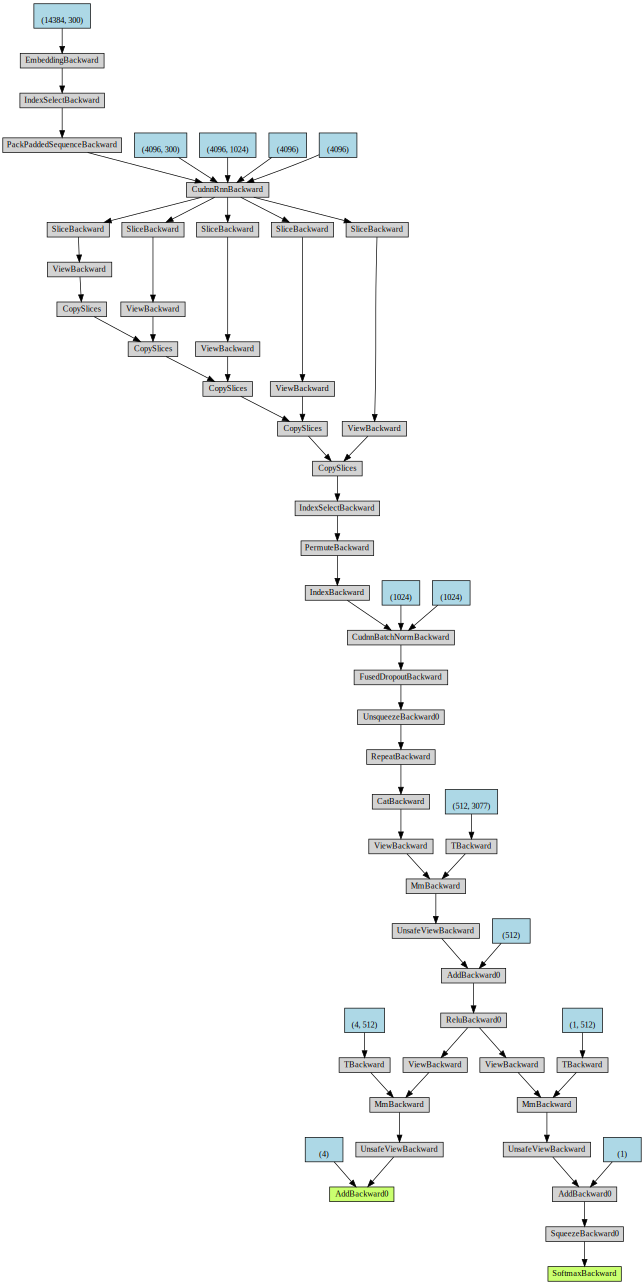

In [37]:
from torchviz import make_dot
make_dot(pred)

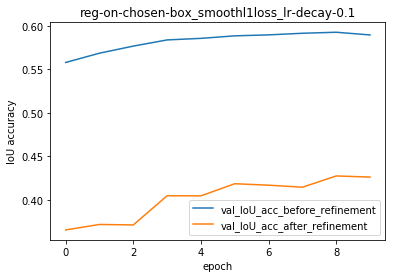

In [95]:
import matplotlib.pyplot as plt
plt.xlabel('epoch')
plt.ylabel('IoU accuracy')
plt.title('reg-on-chosen-box_smoothl1loss_lr-decay-0.1')
plt.plot(process['val_IoU_acc_before_refinement'], label='val_IoU_acc_before_refinement')
plt.plot(process['val_IoU_acc_after_refinement'], label='val_IoU_acc_after_refinement')
plt.legend()

In [ ]:
with open("/home/wenjian/Internship/DDPN_transfer/outputs/2019-08-06_19-53-21_gereral-dictionary-mapping_ranking-loss-only/process.dct", "rb") as f:
    loaded_process = pickle.load(f)

## Test set accuracy

In [22]:
en_vocab = len(training_corpus_dct.token2id)

model_test = DDPN(cfg, vocab_size=en_vocab)

#model_en.load_state_dict(torch.load(english_pretrained_model_path, map_location=device))
model_to_test_path = pretrained_model_path
checkpoint = torch.load(model_to_test_path, map_location=device)

if not cfg.regression_loss:  # In case of the pretrained model has regression loss while now not
    try:
        checkpoint['model_state_dict'].pop("fc_regression.weight")
        checkpoint['model_state_dict'].pop("fc_regression.bias")
    except KeyError:
        pass

model_test.load_state_dict(checkpoint['model_state_dict'])

model_test.to(device)

DDPN(
  (embedding): Embedding(14384, 300)
  (lstm): LSTM(300, 1024)
  (fc1): Linear(in_features=3077, out_features=512, bias=True)
  (fc_rank): Linear(in_features=512, out_features=1, bias=True)
  (batchnorm): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (softmax): Softmax(dim=1)
)

In [23]:
# Parameters
params = {'batch_size': 64,
          'num_workers': 2}
test_generator = data.DataLoader(test_set, shuffle=False, **params)

In [24]:
# For statistics of IoU score
test_all_ious_original = []
if cfg.regression_loss:
    test_all_ious_refined = []
    
print(f"Evaluating on test set: {len(test_set)} samples" )
with torch.no_grad():      
    for test_batch_counter, (inputs, gt_bboxes, _) in enumerate(test_generator):
        Xs, queries = inputs
        #print("val_batch_counter", val_batch_counter)
        #print("Xs", Xs.size())
        #print("queries", len(queries))
        #print("gt_bboxes", gt_bboxes.size())

        Qs, seq_lengths = preprocess_query(queries)

        model_test.eval()

        Xs, Qs, gt_bboxes = Xs.to(device), Qs.to(device), gt_bboxes.to(device)

        test_pred = model_test(Xs, Qs, seq_lengths)
        test_targ = (get_softlable(Xs, gt_bboxes), gt_bboxes)
#         try:
#             val_loss = loss_func(val_pred, val_targ)
#         except AssertionError as e:
#             print(f"epoch {epoch}, val, batch: {val_batch_counter}")
#             with open("debug.log", 'a') as log:
#                 log.write(f"epoch {epoch}, val, batch: {val_batch_counter}\n")
#             raise e
#         test_losses_by_epoch.append(val_loss.item())
#         val_loss_average_by_epoch += val_loss.item()*Xs.size(0)
        #logger.add_scalar('val_losses_all_batches', val_losses, val_batch_counter)

#         print(f"\repoch {epoch}, validation phase, batch {val_batch_counter}/{len(validation_generator)}, val_loss={val_loss.item()}", end='')
#         logger.add_scalar("val_loss_by_batch", val_loss.item(), val_batch_counter_total)

        # Statistics of IoU score
        if cfg.regression_loss:
            ious_original, ious_refined = calculate_IoU_scores(Xs, test_pred, gt_bboxes)
        else:
            ious_original = calculate_IoU_scores(Xs, test_pred, gt_bboxes)
        test_all_ious_original = test_all_ious_original + ious_original.tolist()
        if cfg.regression_loss:
            test_all_ious_refined = test_all_ious_refined + ious_refined.tolist()
    
    good_original = torch.tensor(test_all_ious_original) > 0.5     
    print("Test set: good bounding box based on original bounding box:", good_original.sum().item())
    acc_original = good_original.sum().float()/len(test_set)
    print("Test set: accuracy based on original bounding box:", acc_original.item())

Evaluating on test set: 2789 samples
Test set: good bounding box based on original bounding box: 1737
Test set: accuracy based on original bounding box: 0.6228038668632507


word2word translate: 62.28%

In [29]:
import PIL
from PIL import Image, ImageDraw
import os

def draw_bounding_box(filepath_sourceimage, bbox, color, output_dir="", output_name=""):
    """
    Arguemnts:
        filepath: the path to the image file.
        bbox: a 4-element list to describe a bounding box; format: [x1,y1,x2,y2]
        color: a 3-element tuple or a string to describe a color. Example(pure red): (255,0,0) or "#ff0000" or "red"
    """
    img_name = os.path.basename(filepath_sourceimage)

    if isinstance(color, str):
        color = PIL.ImageColor.getrgb(color)

    img = Image.open(filepath_sourceimage).convert("RGBA")
    tmp = Image.new('RGBA', img.size, (0,0,0,0))
    draw = ImageDraw.Draw(tmp)
    draw.rectangle(bbox, fill=color+(32,), outline=color, width=2)
    img = Image.alpha_composite(img, tmp)
    img = img.convert("RGB") # Remove alpha for saving
    if output_name == "":
        out_img_name = 'bbox_' + img_name
    else:
        out_img_name = output_name
    output_path = os.path.join(output_dir, out_img_name)
    img.save(output_path)
    return output_path

In [30]:
def draw_multiple_bounding_boxes(filepath_sourceimage, bbox_color_tuple_list, output_dir="", output_name=""):
    """
    Arguemnts:
        filepath: the path to the image file.
        bbox_color_tuple_list: a list of (bbox, color) tuple, where
            bbox: a 4-element list to describe a bounding box; format: [x1,y1,x2,y2]
            color: a 3-element tuple or a string to describe a color. Example(pure red): (255,0,0) or "#ff0000" or "red"
    """
    img_name = os.path.basename(filepath_sourceimage)
    
    img = Image.open(filepath_sourceimage).convert("RGBA")
    
    
    for bbox, color in bbox_color_tuple_list:
        if isinstance(color, str):
            color = PIL.ImageColor.getrgb(color)
        tmp = Image.new('RGBA', img.size, (0,0,0,0))
        draw = ImageDraw.Draw(tmp)
        draw.rectangle(bbox, fill=color+(32,), outline=color, width=2)
        img = Image.alpha_composite(img, tmp)
        
    img = img.convert("RGB") # Remove alpha for saving
    if output_name == "":
        out_img_name = 'bbox_' + img_name
    else:
        out_img_name = output_name     
    output_path = os.path.join(output_dir, out_img_name)
    img.save(output_path)
    return output_path

In [89]:
# Separate this function from loss_wrapper to print two losses separately 
# Don't forget to synchronize this function when the loss_wrapper is modified
# Noted that no matter regularization loss is trained on chosen proposal or on all proposals, the loss in this function should always work on the chosen proposal. 
def loss_wrapper_testing(delta, epsilon):
    def my_loss(predict, target):  # predict is expected to be (s,t), target their ground truth value
        s, t = predict
        gt_s, gt_t = target
        #print("s", s.size())   # --> s torch.Size([64, 100])
        #print("gt_s", gt_s.size())   # --> gt_s torch.Size([64, 100])
        #print("t", t.size())   # --> t torch.Size([64, 100, 4])
        #print("gt_t", gt_t.size())   # --> gt_t torch.Size([64, 4])
        s = torch.add(s, torch.tensor(epsilon))  # In order to avoid 0 in the denominator
        try:
            assert not torch.isnan(s).any()
            assert not torch.isinf(s).any()
            assert not torch.isnan(t).any()
            assert not torch.isinf(t).any()
            assert not torch.isnan(gt_s).any()
            assert not torch.isinf(gt_s).any()
            assert not torch.isnan(gt_t).any()
            assert not torch.isinf(gt_t).any()
            loss_ranking = F.kl_div(torch.log(s), gt_s, reduction='batchmean') 
            assert not torch.isnan(loss_ranking).any()
            assert not torch.isinf(loss_ranking).any()
            N = t.size()[1]
            #print('gt_t after repeat', gt_t.unsqueeze(1).repeat(1,N,1).size())
            
            
            proposal_chosen = torch.argmax(s, dim=1)
            batch_size = s.size()[0]
            t_chosen = t[torch.arange(batch_size),proposal_chosen,:]  # t_chosen shape is expected to be (batch_size, 4)
            #print("t_chosen", t_chosen.size())
            loss_regression = F.smooth_l1_loss(t_chosen, gt_t, reduction='none')
            
            #loss_regression = F.smooth_l1_loss(t, gt_t.unsqueeze(1).repeat(1,N,1), reduction='mean')
            
            
            #print("loss_regression", loss_regression)
            assert not torch.isnan(loss_regression).any()
            assert not torch.isinf(loss_regression).any()
            
            print("ranking_loss", loss_ranking)
            print("regression_loss", loss_regression)
            #my_loss.counter += 1 
            
        except AssertionError as e:
            torch.set_printoptions(profile='full')
            print('s\n', s)
            print('t\n', t)
            print('gt_s\n', gt_s)
            print('gt_t\n', gt_t)
            with open("debug.log", 'w') as log:
                log.write('s\n')
                log.write(str(s))
                log.write('gt_s\n')
                log.write(str(gt_s))
            torch.set_printoptions(profile='default')
            raise e
           
        return delta*loss_ranking + torch.mean(loss_regression)  # Manual reduction
        #return loss_ranking + gamma*loss_regression
        #return loss_ranking 
    #my_loss.counter = 0
    return my_loss
loss_func_testing = loss_wrapper_testing(cfg.DELTA, cfg.epsilon)

In [106]:






if not os.path.exists("./visualization/"):
    os.mkdir("./visualization/")

validation_generator_for_visualization = data.DataLoader(validation_set, shuffle=False, batch_size=64)

with torch.no_grad():
        
    batch_number = 1 # batch_number begins by 0, until last batch in validation set

    #for inputs, gt_bboxes in validation_generator:
    it = iter(validation_generator_for_visualization)
    for i in range(batch_number+1):
        inputs, gt_bboxes, IDs = next(it)
    Xs, queries = inputs
    img_ids, obj_ids, img_ws, img_hs = IDs
    #print("val_batch_counter", val_batch_counter)
    #print("Xs", Xs.size())
    #print("queries", len(queries))
    #print("gt_bboxes", gt_bboxes.size())

    Qs, seq_lengths = preprocess_query(queries)

    model.eval()

    Xs, Qs, gt_bboxes = Xs.to(device), Qs.to(device), gt_bboxes.to(device)

    val_pred = model(Xs, Qs, seq_lengths)
    val_targ = (get_softlable(Xs, gt_bboxes), gt_bboxes)
    try:
        val_loss = loss_func_testing(val_pred, val_targ)
    except AssertionError as e:
        print(f"epoch {epoch}, val, batch: {val_batch_counter}")
        with open("debug.log", 'a') as log:
            log.write(f"epoch {epoch}, val, batch: {val_batch_counter}\n")
        raise e
    print(val_loss.item())


    # Statistics of IoU score

    s, t = val_pred
    proposal_chosen = torch.argmax(s, dim=1)
    batch_size = Xs.size()[0]
    gt_bboxes = gt_bboxes.unsqueeze(1) # add a dimension 1 at the middle is to use the function IoU
    bboxes_chosen_original = Xs[torch.arange(batch_size),proposal_chosen,-5:-1].unsqueeze(1)
    bboxes_chosen_refined = t[torch.arange(batch_size),proposal_chosen,:].unsqueeze(1)
    #print(bboxes_chosen.size())
    ious_original = IoU(bboxes_chosen_original, gt_bboxes).squeeze()  
    ious_refined = IoU(bboxes_chosen_refined, gt_bboxes).squeeze() 
    
    
    def get_bbox_in_original_scale(boxes, img_ws, img_hs, sample_in_batch):
        box = boxes[sample_in_batch].tolist()[0]  # [0] is to remove a pair of []
        #print(box)
        #print(img_ws[sample_in_batch])
        #print(img_hs[sample_in_batch])
        #print(img_ws[sample_in_batch].data.cpu().numpy())
        box[0] *= img_ws[sample_in_batch].item()
        box[1] *= img_hs[sample_in_batch].item()
        box[2] *= img_ws[sample_in_batch].item()
        box[3] *= img_hs[sample_in_batch].item()
        #print("box[0]", box[0])
        return box
    
    for sample_in_batch in range(0,64): # Change here to see a different sample

        gt_box = get_bbox_in_original_scale(gt_bboxes, img_ws, img_hs, sample_in_batch)
        first_box = get_bbox_in_original_scale(bboxes_chosen_original, img_ws, img_hs, sample_in_batch)
        refined_first_box = get_bbox_in_original_scale(bboxes_chosen_refined, img_ws, img_hs, sample_in_batch)

        boxes_colors = [(gt_box, "green"),
                        (first_box, "yellow"),
                        (refined_first_box, "red")
                        ]

        img_path_source = os.path.join(img_dir, img_ids[sample_in_batch]+'.jpg')  
        query_number = batch_number*batch_size+sample_in_batch
        output_path = draw_multiple_bounding_boxes(img_path_source, boxes_colors, output_dir = "./visualization/",
                output_name=str(query_number) + "_" + img_ids[sample_in_batch]+'_'+obj_ids[sample_in_batch]+'_'+queries[sample_in_batch]+'.jpg')
        print(query_number, img_ids[sample_in_batch], obj_ids[sample_in_batch], queries[sample_in_batch], ious_original[sample_in_batch].item(), ious_refined[sample_in_batch].item())

#os.system("xdg-open "+output_path)



ranking_loss tensor(0.0051, device='cuda:3')
regression_loss tensor([[3.5208e-04, 8.3301e-03, 1.4395e-07, 1.8458e-04],
        [1.0197e-04, 9.0384e-03, 1.7739e-03, 1.9695e-02],
        [1.8238e-03, 1.3999e-02, 1.1021e-02, 5.7377e-03],
        [5.4663e-03, 1.0063e-03, 2.3000e-05, 2.8862e-04],
        [4.4660e-05, 7.2171e-03, 5.9437e-05, 1.2161e-05],
        [3.9638e-03, 1.1866e-02, 8.0416e-05, 1.4272e-03],
        [1.0353e-05, 7.8609e-03, 1.2517e-06, 4.1720e-04],
        [7.5158e-03, 1.2149e-02, 1.0817e-05, 5.9755e-04],
        [9.5321e-03, 3.4907e-02, 1.0334e-02, 5.2831e-03],
        [9.3181e-04, 9.4682e-05, 2.0898e-03, 2.3649e-05],
        [8.8877e-05, 2.0509e-02, 4.2518e-06, 3.3216e-03],
        [3.1346e-03, 1.3755e-07, 2.9779e-04, 2.1452e-04],
        [3.4714e-02, 5.5310e-04, 1.7211e-02, 1.7143e-02],
        [1.1393e-02, 1.4931e-02, 9.1838e-03, 5.4214e-03],
        [4.1188e-03, 2.1181e-03, 8.4488e-05, 4.4536e-07],
        [3.2111e-04, 2.1581e-04, 6.4923e-03, 9.9500e-05],
        [1.

In [31]:
phase = "test"

folder = "./test-visualization_google-translation/"

if not os.path.exists(folder):
    os.mkdir(folder)

if phase == 'val':
    generator_for_visualization = data.DataLoader(validation_set, shuffle=False, batch_size=64)
elif phase == 'test':
    generator_for_visualization = data.DataLoader(test_set, shuffle=False, batch_size=64)

    
model_test = DDPN(cfg, vocab_size=en_vocab)

#model_en.load_state_dict(torch.load(english_pretrained_model_path, map_location=device))
# model_to_test_path = os.path.join(output_dir, "checkpoint_1.tar")
# checkpoint = torch.load(model_to_test_path, map_location=device)
# model_test.load_state_dict(checkpoint['model_state_dict'])

# model_test.to(device)


model_to_test_path = "/home/wenjian/code/experiments/2019-08-17_19-26-48_L1-gt-softlabel_drop0.5_checkpoint_4_69.30.tar"
checkpoint = torch.load(model_to_test_path, map_location=device)

if not cfg.regression_loss:  # In case of the pretrained model has regression loss while now not
    try:
        checkpoint['model_state_dict'].pop("fc_regression.weight")
        checkpoint['model_state_dict'].pop("fc_regression.bias")
    except KeyError:
        pass

model_test.load_state_dict(checkpoint['model_state_dict'])

model_test.to(device)

DDPN(
  (embedding): Embedding(14384, 300)
  (lstm): LSTM(300, 1024)
  (fc1): Linear(in_features=3077, out_features=512, bias=True)
  (fc_rank): Linear(in_features=512, out_features=1, bias=True)
  (batchnorm): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.5)
  (softmax): Softmax()
)

In [37]:
# Test set or val set

print("loaded checkpoint:", model_to_test_path)






with torch.no_grad():
        
    batch_number = 3 # batch_number begins by 0, until last batch in the data set

    #for inputs, gt_bboxes in generator:
    it = iter(generator_for_visualization)
    for i in range(batch_number+1):
        inputs, gt_bboxes, IDs = next(it)
    Xs, queries = inputs
    img_ids, obj_ids, img_ws, img_hs = IDs
    #print("val_batch_counter", val_batch_counter)
    #print("Xs", Xs.size())
    #print("queries", len(queries))
    #print("gt_bboxes", gt_bboxes.size())

    Qs, seq_lengths = preprocess_query(queries)

    model_test.eval()

    Xs, Qs, gt_bboxes = Xs.to(device), Qs.to(device), gt_bboxes.to(device)

    pred = model_test(Xs, Qs, seq_lengths)
    targ = (get_softlable(Xs, gt_bboxes), gt_bboxes)
    #loss = loss_func_testing(pred, targ)
    loss = loss_func(pred, targ)
    print(loss.item())


    # Statistics of IoU score

    s, t = pred
    proposal_chosen = torch.argmax(s, dim=1)
    batch_size = Xs.size()[0]
    gt_bboxes = gt_bboxes.unsqueeze(1) # add a dimension 1 at the middle is to use the function IoU
    bboxes_chosen_original = Xs[torch.arange(batch_size),proposal_chosen,-5:-1].unsqueeze(1)
    #bboxes_chosen_refined = t[torch.arange(batch_size),proposal_chosen,:].unsqueeze(1)
    #print(bboxes_chosen.size())
    ious_original = IoU(bboxes_chosen_original, gt_bboxes).squeeze()  
    #ious_refined = IoU(bboxes_chosen_refined, gt_bboxes).squeeze() 
    
    
    def get_bbox_in_original_scale(boxes, img_ws, img_hs, sample_in_batch):
        box = boxes[sample_in_batch].tolist()[0]  # [0] is to remove a pair of []
        #print(box)
        #print(img_ws[sample_in_batch])
        #print(img_hs[sample_in_batch])
        #print(img_ws[sample_in_batch].data.cpu().numpy())
        box[0] *= img_ws[sample_in_batch].item()
        box[1] *= img_hs[sample_in_batch].item()
        box[2] *= img_ws[sample_in_batch].item()
        box[3] *= img_hs[sample_in_batch].item()
        #print("box[0]", box[0])
        return box
    
    for sample_in_batch in range(0,64): # Change here to see different samples

        gt_box = get_bbox_in_original_scale(gt_bboxes, img_ws, img_hs, sample_in_batch)
        top_rank_box = get_bbox_in_original_scale(bboxes_chosen_original, img_ws, img_hs, sample_in_batch)
        #refined_top_rank_box = get_bbox_in_original_scale(bboxes_chosen_refined, img_ws, img_hs, sample_in_batch)

#         boxes_colors = [(gt_box, "green"),
#                         (top_rank_box, "yellow"),
#                         (refined_top_rank_box, "red")
#                         ]

        boxes_colors = [(gt_box, "green"),
                        (top_rank_box, "yellow"),
                        ]

        img_path_source = os.path.join(img_dir, img_ids[sample_in_batch]+'.jpg')  
        query_number = batch_number*batch_size+sample_in_batch
        output_path = draw_multiple_bounding_boxes(img_path_source, boxes_colors, output_dir = folder,
                output_name=str(query_number) + "_" + img_ids[sample_in_batch]+'_'+obj_ids[sample_in_batch]+'_'+queries[sample_in_batch]+'.jpg')
        print(query_number, img_ids[sample_in_batch], obj_ids[sample_in_batch], queries[sample_in_batch], ious_original[sample_in_batch].item())

#os.system("xdg-open "+output_path)

loaded checkpoint: /home/wenjian/code/experiments/2019-08-17_19-26-48_L1-gt-softlabel_drop0.5_checkpoint_4_69.30.tar
1.4053672552108765
192 151970521 15557 blue 0.5710521340370178
193 151970521 15561 a black leather bag 0.41171401739120483
194 151970521 15555 bench 0.5994035601615906
195 151970521 15559 people 0.4411853849887848
196 151970521 15554 a limousine 0.21216724812984467
197 1526325728 15644 the brown dog 0.8459575176239014
198 155210731 16150 a woman 0.6949360966682434
199 155210731 16154 a laundry basket 0.7720130085945129
200 155210731 16155 tissues 0.2899075746536255
201 157910841 16868 a man 0.8442575931549072
202 1579198375 16883 a woman 0.7630705237388611
203 1579198375 16885 a guitarist 0.7273948788642883
204 1579206585 16891 a guitarist 0.5605291128158569
205 1579206585 16893 a nightclub 0.4734116792678833
206 157955034 16921 a child 0.6101589202880859
207 157955034 16922 a garden chair 0.5897736549377441
208 160792599 17430 two women 0.33142876625061035
209 160792599

In [ ]:
# This block is to draw all bounding box proposals on one image.  

visualization_dir = "./visualization_gt2/"


if not os.path.exists(visualization_dir):
    os.mkdir(visualization_dir)

validation_generator_for_visualization = data.DataLoader(validation_set, shuffle=False, batch_size=64)


batch_number = 1 # batch_number begins by 0, until last batch in validation set

#for inputs, gt_bboxes in validation_generator:
it = iter(validation_generator_for_visualization)
for i in range(batch_number+1):
    inputs, gt_bboxes, IDs = next(it)
Xs, queries = inputs
img_ids, obj_ids, img_ws, img_hs = IDs
#print("val_batch_counter", val_batch_counter)
#print("Xs", Xs.size())
#print("queries", len(queries))



def get_bbox_in_original_scale_all_proposals(boxes, img_ws, img_hs, sample_in_batch):
    #print(boxes)
    box = boxes.clone()
    #print(box[0])
    #print(img_ws[sample_in_batch])
    #print(img_hs[sample_in_batch])
    #print(img_ws[sample_in_batch].data.cpu().numpy())
    box[:,0] *= img_ws[sample_in_batch]
    box[:,1] *= img_hs[sample_in_batch]
    box[:,2] *= img_ws[sample_in_batch]
    box[:,3] *= img_hs[sample_in_batch]
    print("box", box)
    return box.tolist()

for sample_in_batch in range(0,64): # Change here to see a different sample

    sample_in_batch = 0

    proposals = Xs[sample_in_batch,:,-5:-1]
    proposal_list = get_bbox_in_original_scale_all_proposals(proposals, img_ws, img_hs, sample_in_batch)
    
     
    #print(proposal_list[0])
    
    img_path_source = os.path.join(img_dir, img_ids[sample_in_batch]+'.jpg')  
    im = Image.open(img_path_source)
    
    print(len(proposal_list[i]))
    
    for i in range(len(proposal_list)):
        ImageDraw.ImageDraw(im).rectangle(proposal_list[i], outline="yellow", width=0)
        
    query_number = batch_number*batch_size+sample_in_batch
#     output_path = draw_multiple_bounding_boxes(img_path_source, boxes_colors, output_dir = visualization_dir,
#             output_name=str(query_number) + "_" + img_ids[sample_in_batch]+'_'+obj_ids[sample_in_batch]+'_'+queries[sample_in_batch]+'.jpg')
    im.save(os.path.join(visualization_dir, str(query_number) + "_" + img_ids[sample_in_batch]+'_'+obj_ids[sample_in_batch]+'_'+queries[sample_in_batch]+'.jpg'))
    print(query_number, img_ids[sample_in_batch], obj_ids[sample_in_batch], queries[sample_in_batch])
    
    break

In [56]:
torch.isnan(torch.tensor([1,2]))

tensor([0, 0], dtype=torch.uint8)

In [100]:
Qs

tensor([[   0,    0,    0,    0,    0,    0,    0,    0,   17,    0,    0,    0,
            0,    0,    0,   17,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0],
        [   0,    0,    0,    0,    0,    0,    0,    0,  130,  239,    0,    0,
            0,  239,    0,   31,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,   17,    0,    0,    0,    0,   71,
            0,    0,    0,    0,    0,    0,    0,    0,   17,    0,    0,    0,
           17,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0],
        [   0,    0,    0,    0,    0,    0,    0,    0,  186,  186,   17,    0,
            0,  186,    0,   30,   44,   

A blog on tips of deep learning debug

In [67]:
with open(pytorch_result_save_path+loss_filename, 'wb') as fp:
    pickle.dump(process, fp)

In [68]:
model.eval() # Do this before saving the model when dropout or batch normalization is involved. https://pytorch.org/tutorials/beginner/saving_loading_models.html
# Save model's learnable parameters
torch.save(model.state_dict(), pytorch_model_save_path+pth_filename)
# Save checkpoint
torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,

            }, pytorch_checkpoint_save_path+checkpoint_filename)

## output bounding box

In [32]:
# Load model
if False:
    if cfg.use_pretrained_word_embedding == None:
        model = DDPN(len(training_corpus_dct.token2id), cfg)
    elif cfg.use_pretrained_word_embedding == "GloVe":
        model = DDPN(len(training_corpus_dct.token2id), cfg, glove.vectors)
    model.load_state_dict(torch.load('/home/wenjian/Internship/DDPN_draft/model/ddpn.pth'))

AssertionError: Error: you are using non-pretraind embedding, and vocab_size is not an integer, but <__main__.CFG object at 0x7fb52806ee80>.

In [57]:

model.to(device)
model.eval()


with torch.no_grad():
    print(f"Evaluating the model on the validation set ({len(validation_set)} samples)...")
    all_ious_original = []
    all_ious_refined = []
    counter = 0
    for inputs, gt_bboxes in validation_generator:
        Xs, queries = inputs
        batch_size = Xs.size()[0]
        """
        indices = [training_corpus_dct.doc2idx([stemmer.stem(w) for w in word_tokenize(q)]) for q in queries]
        #print("---aaa---\n", indices)
        # Gensim assign -1 to unknown word in the dictionary. 
        # Pytorch embedding, however, don't support negative index. 
        # So we kept 1 for unknown word when building Gensim dictionary, and convert -1 to 1 now
        indices = [[idx if idx!=-1 else 1 for idx in row] for row in indices]
        #print("---bbb---\n", indices)

        Qs_before_padding = [torch.tensor(row) for row in indices]
        if cfg.use_pretrained_word_embedding == None:
            padding_value = 0
        elif cfg.use_pretrained_word_embedding == "GloVe":
            padding_value = 1  # 1 is '.', since in GloVe there is no empty word token
        #Qs = nn.utils.rnn.pad_sequence(Qs_before_padding, batch_first=False)
        Qs = pad_sequence_right_alignment(Qs_before_padding, batch_first=False, padding_value=padding_value)
        """
        Qs, seq_lengths = preprocess_query(queries)
        
        model.eval()

        Xs, Qs, gt_bboxes = Xs.to(device), Qs.to(device), gt_bboxes.to(device)

        val_pred = model(Xs, Qs, seq_lengths)
        
        s, t = val_pred
        
        proposal_chosen = torch.argmax(s, dim=1)
        
        gt_bboxes = gt_bboxes.unsqueeze(1) # add a dimension 1 at the middle is to use the function IoU
        bboxes_chosen_original = Xs[torch.arange(batch_size),proposal_chosen,-5:-1].unsqueeze(1)
#         bboxes_chosen_refined = t[torch.arange(batch_size),proposal_chosen,:].unsqueeze(1)
        #print(bboxes_chosen.size())
        ious_original = IoU(bboxes_chosen_original, gt_bboxes)  
#         ious_refined = IoU(bboxes_chosen_refined, gt_bboxes) 
        
        #print(ious.size())
        all_ious_original = all_ious_original + ious_original.squeeze().tolist()
#         all_ious_refined = all_ious_refined + ious_refined.squeeze().tolist()
        
        counter += 1
        #if counter%10 == 0:
        #    print(counter)

good_original = torch.tensor(all_ious_original) > 0.5     
print("good bounding box based on original bounding box:", good_original.sum())
acc_original = good_original.sum().float()/len(validation_set)
print("accuracy based on original bounding box:", acc_original)

# good_refined = torch.tensor(all_ious_refined) > 0.5
# print("good bounding box refined:", good_refined.sum())
# acc_refined = good_refined.sum().float()/len(validation_set)
# print("accuracy of refined bounding box:", acc_refined)

Evaluating the model on the validation set (14526 samples)...
good bounding box based on original bounding box: tensor(9112)
accuracy based on original bounding box: tensor(0.6273)


Without pretrained embedding:
With Wenjian's feature:
Epochs --> accuracy based on original bounding box --> accuracy of refined bounding box
3 epochs --> 20.30% --> 21.56% <br>
10 epochs --> 20.16% --> 21.70% <br>
20 epochs --> 18.88% --> 23.67%

With Otani's feature:
3 epochs --> 24.15% --> 19.12% <br>

Only consider ranking loss: <br>
3 epochs --> 57.83% (before considering multiple bounding boxes) <br>
3 epochs --> 62.73% (after considering multiple bounding boxes)

## Random selection test

In [141]:
import random
print(f"Evaluating the model on the validation set ({len(validation_set)} samples)...")
all_ious_original = []
all_ious_refined = []
counter = 0
random.seed()
for inputs, gt_bboxes in validation_generator:
    Xs, queries = inputs
    batch_size = Xs.size()[0]
    
    
    
    proposal_chosen = [random.randint(0,99) for i in range(100)]

    gt_bboxes = gt_bboxes.unsqueeze(1) # add a dimension 1 at the middle is to use the function IoU
    bboxes_chosen_original = Xs[torch.arange(batch_size),proposal_chosen,-5:-1].unsqueeze(1)
    #print(bboxes_chosen.size())
    ious_original = IoU(bboxes_chosen_original, gt_bboxes)  

    #print(ious.size())
    all_ious_original = all_ious_original + ious_original.squeeze().tolist()

    counter += 1
    #if counter%10 == 0:
    #    print(counter)

good_original = torch.tensor(all_ious_original) > 0.5     
print("good bounding box based on original bounding box:", good_original.sum())
acc_original = good_original.sum().float()/len(validation_set)
print("accuracy based on original bounding box:", acc_original)


tensor(0.2028)


In [49]:
# On test set

# Parameters
params = {'batch_size': 64,
          'num_workers': 8}
test_generator = data.DataLoader(test_set, shuffle=True, **params)

import random
print(f"Evaluating the model on the test set ({len(test_set)} samples)...")
all_ious_original = []

counter = 0
#random.seed()
for test_batch_counter, (inputs, gt_bboxes, _) in enumerate(test_generator):
    Xs, queries = inputs
    batch_size = Xs.size()[0]
    
    
    
    proposal_chosen = [random.randint(0,99) for i in range(batch_size)]

    gt_bboxes = gt_bboxes.unsqueeze(1) # add a dimension 1 at the middle is to use the function IoU
    bboxes_chosen_original = Xs[torch.arange(batch_size),proposal_chosen,-5:-1].unsqueeze(1)
    #print(bboxes_chosen.size())
    ious_original = IoU(bboxes_chosen_original, gt_bboxes)  

    #print(ious.size())
    all_ious_original = all_ious_original + ious_original.squeeze().tolist()

    counter += 1
    #if counter%10 == 0:
    #    print(counter)

good_original = torch.tensor(all_ious_original) > 0.5     
print("good bounding box based on original bounding box:", good_original.sum())
acc_original = good_original.sum().float()/len(validation_set)
print("accuracy based on original bounding box:", acc_original)

Evaluating the model on the test set (14476 samples)...
good bounding box based on original bounding box: tensor(678)
accuracy based on original bounding box: tensor(0.0467)


## Refined bounding box

In [142]:
with torch.no_grad():
    all_ious = []
    counter = 0
    for inputs, gt_bboxes in validation_generator:
        Xs, queries = inputs
        batch_size = Xs.size()[0]
        indices = [training_corpus_dct.doc2idx([stemmer.stem(w) for w in word_tokenize(q)]) for q in queries]
        #print("---aaa---\n", indices)
        # Gensim assign -1 to unknown word in the dictionary. 
        # Pytorch embedding, however, don't support negative index. 
        # So we kept 1 for unknown word when building Gensim dictionary, and convert -1 to 1 now
        indices = [[idx if idx!=-1 else 1 for idx in row] for row in indices]
        #print("---bbb---\n", indices)

        Qs_before_padding = [torch.tensor(row) for row in indices]
        Qs = nn.utils.rnn.pad_sequence(Qs_before_padding, batch_first=False)

        model.eval()

        Xs, Qs, gt_bboxes = Xs.to(device), Qs.to(device), gt_bboxes.to(device)

        val_pred = model(Xs, Qs)
        
        s, t = val_pred
        #print("t", t.size())
        
        proposal_chosen = torch.argmax(s, dim=1)
        
        gt_bboxes = gt_bboxes.unsqueeze(1) # add a dimension 1 at the middle is to use the function IoU
        bboxes_chosen_refined = t[torch.arange(batch_size),proposal_chosen,:].unsqueeze(1)
        #print(bboxes_chosen.size())
        ious = IoU(bboxes_chosen_refined, gt_bboxes)  
        
        #print(ious.size())
        all_ious = all_ious + ious.squeeze().tolist()
        
        counter += 1
        print(counter)
        

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227


In [143]:
good_refined = torch.tensor(all_ious) > 0.5
print(good_refined.sum())

tensor(3132)


In [144]:
print(good_refined.sum().float()/len(validation_set))
# First try (3 epochs) --> 21.56%
# Second try (20 epochs) --> 23.67%

tensor(0.2156)


## Statistics on validation set

In [30]:
# Attention! this function only work on CPU. Relaod the oringal version after using this version
def intersect(box_a, box_b):  # Tackle with N (like 100) box pairs at the same time
    #print(box_a.type())
    #print(box_b.type())
    inter_xmin=torch.max(box_a[:,:,0], box_b[:,:,0])
    inter_xmax=torch.min(box_a[:,:,2], box_b[:,:,2])
    inter_ymin=torch.max(box_a[:,:,1], box_b[:,:,1])
    inter_ymax=torch.min(box_a[:,:,3], box_b[:,:,3])
    inter = torch.max((inter_xmax-inter_xmin).float(), torch.tensor(0).float().to('cpu')) * torch.max((inter_ymax-inter_ymin).float(), torch.tensor(0).float().to('cpu'))
    return inter
thre = 0.5
good_proposal = []
for i in range(len(validation_set)):
    iou = iou_pass_threshold(validation_set[i][0][0].unsqueeze(0),validation_set[i][1], thre)
    
    good_proposal.append(iou.sum())
    
    if i%100 == 0:
        print("i=", i, ", average=", np.array(good_proposal).mean())
#print("Finally,", counter, "examples pass the threshold.")

i= 0 , average= 1.0
i= 100 , average= 4.554455445544554
i= 200 , average= 4.3283582089552235
i= 300 , average= 4.212624584717608
i= 400 , average= 4.082294264339152
i= 500 , average= 4.06187624750499
i= 600 , average= 4.2579034941763725
i= 700 , average= 4.272467902995721
i= 800 , average= 4.253433208489389
i= 900 , average= 4.314095449500555
i= 1000 , average= 4.393606393606394
i= 1100 , average= 4.464123524069028
i= 1200 , average= 4.385512073272273
i= 1300 , average= 4.467332820906995
i= 1400 , average= 4.599571734475375
i= 1500 , average= 4.574950033311126
i= 1600 , average= 4.553404122423485
i= 1700 , average= 4.577895355673133
i= 1800 , average= 4.520821765685731
i= 1900 , average= 4.52656496580747
i= 2000 , average= 4.491754122938531
i= 2100 , average= 4.488338886244645
i= 2200 , average= 4.534756928668787
i= 2300 , average= 4.515428074750108
i= 2400 , average= 4.555601832569763
i= 2500 , average= 4.591363454618152
i= 2600 , average= 4.549404075355633
i= 2700 , average= 4.611625

In [121]:
4.04/76.5  # There are 76.5 proposals per image on average for the whole Flickr30k dataset. 

0.05281045751633987

In [ ]:
with torch.no_grad():
    all_ious = []
    counter = 0
    for inputs, gt_bboxes in validation_generator:
        Xs, queries = inputs
        batch_size = Xs.size()[0]
        
        
        
        
        
        
        gt_bboxes = gt_bboxes.unsqueeze(1) # add a dimension 1 at the middle is to use the function IoU
        bboxes_chosen = Xs[torch.arange(batch_size),proposal_chosen,-5:-1].unsqueeze(1)
        #print(bboxes_chosen.size())
        ious = IoU(bboxes_chosen, gt_bboxes)  
        
        #print(ious.size())
        all_ious = all_ious + ious.squeeze().tolist()
        
        counter += 1
        print(counter)
        

## Random tests

In [44]:
torch.tensor([3,5]).float() / torch.tensor(4)

tensor([0.7500, 1.2500])

In [69]:
a = torch.tensor([[1,2,3],[4,5,6]])

In [72]:
torch.argmax(a, dim=1)

tensor([2, 2])

In [95]:
a>1.5

tensor([[0, 1, 1],
        [1, 1, 1]], dtype=torch.uint8)

In [97]:
a*(a>1.5).long()

tensor([[0, 2, 3],
        [4, 5, 6]])

In [22]:
a = np.array([[1,2],[3,4]])

In [24]:
a.tolist()

[[1, 2], [3, 4]]

In [25]:
a[:,0]

array([1, 3])

In [79]:
a = np.array((1,2,3))
b = np.array((4,5,6))
c = np.array((7,8,9))
d = np.array((10,11,12))

In [80]:
A = np.column_stack((a,b))
B = np.column_stack((c,d))

In [81]:
AB = np.column_stack((A,B))

In [82]:
ABA = np.column_stack((AB,A))

In [83]:
ABA

array([[ 1,  4,  7, 10,  1,  4],
       [ 2,  5,  8, 11,  2,  5],
       [ 3,  6,  9, 12,  3,  6]])

In [87]:
ABA[[1,2,3],[1,2,3]]

IndexError: index 3 is out of bounds for axis 0 with size 3

In [88]:
x = np.array([[0,1,2],[3,4,5],[6,7,8],[9,10,11],[12,13,14],[15,16,17]])

In [92]:
x = torch.from_numpy(x)

In [93]:
x

tensor([[ 0,  1,  2],
        [ 3,  4,  5],
        [ 6,  7,  8],
        [ 9, 10, 11],
        [12, 13, 14],
        [15, 16, 17]])

In [90]:
y = np.array([0,2,1,0,2,0])
y = torch.from_numpy(y)

In [94]:
x[torch.arange(6), y]

tensor([ 0,  5,  7,  9, 14, 15])

In [41]:
np.stack((AB,A), axis=1)

ValueError: all input arrays must have the same shape

In [88]:
class ManglingTest:
    def __init__(self):
        self.__mangled = 'hello'

    def get_mangled(self):
        return self.__mangled

ManglingTest().get_mangled()


'hello'

In [90]:
ManglingTest().__mangled()

AttributeError: ManglingTest instance has no attribute '__mangled'

In [109]:
x = torch.tensor([1, 2, 3])
x.repeat((4,1))


tensor([[1, 2, 3],
        [1, 2, 3],
        [1, 2, 3],
        [1, 2, 3]])

In [102]:
x.repeat(4, 2).size()

torch.Size([4, 6])

In [104]:
x.repeat(4, 2, 1)

tensor([[[1, 2, 3],
         [1, 2, 3]],

        [[1, 2, 3],
         [1, 2, 3]],

        [[1, 2, 3],
         [1, 2, 3]],

        [[1, 2, 3],
         [1, 2, 3]]])

In [103]:
x.repeat(4, 2, 1).size()


torch.Size([4, 2, 3])

In [120]:
C.a=1

NameError: name 'C' is not defined

In [129]:
def myfunc():
    a = 1
    b = 2
    c = 3
    return (a,b), c
d,e,f = myfunc()
d

ValueError: need more than 2 values to unpack

In [127]:
e

3

In [43]:
a = torch.tensor([[1,2],[3,4]])
b = a.repeat(1,2,1)

In [44]:
b

tensor([[[1, 2],
         [3, 4],
         [1, 2],
         [3, 4]]])

In [46]:
b.size()[1]

4

In [47]:
a = torch.tensor(range(1,13)).view((3,4)).float()
a

tensor([[ 1.,  2.,  3.,  4.],
        [ 5.,  6.,  7.,  8.],
        [ 9., 10., 11., 12.]])

In [48]:
b = torch.tensor(range(1,4)).unsqueeze(1).float()
b.size()

torch.Size([3, 1])

In [50]:
c = a/b
c

tensor([[1.0000, 2.0000, 3.0000, 4.0000],
        [2.5000, 3.0000, 3.5000, 4.0000],
        [3.0000, 3.3333, 3.6667, 4.0000]])

In [51]:
c.size()

torch.Size([3, 4])

In [60]:
c + torch.tensor(0.1)

tensor([[1.1000, 2.1000, 3.1000, 4.1000],
        [2.6000, 3.1000, 3.6000, 4.1000],
        [3.1000, 3.4333, 3.7667, 4.1000]])

tensor(0.1000)

## GPU

In [1]:
import torch
torch.cuda.device_count()

1

In [16]:
torch.cuda.get_device_name('cuda:0')

'GeForce GTX 1080 Ti'

In [19]:
type(torch.device(0))

torch.device

In [3]:
torch.cuda.current_device()

0

In [9]:
torch.cuda.get_device_capability(device=0)

(6, 1)

In [10]:
torch.cuda.get_device_name(device=0)

'GeForce GTX 1080 Ti'

In [11]:
torch.cuda.is_available()

True

In [12]:
torch.cuda.max_memory_allocated(device=0)

0

In [13]:
torch.cuda.memory_allocated(device=0)

0

In [14]:
torch.cuda.memory_cached(device=0)

0

In [117]:
a = torch.tensor([[1,2],[3,4]])

In [118]:
a.to(0)

tensor([[1, 2],
        [3, 4]], device='cuda:0')

In [119]:
a.get_device()

-1

In [66]:
a.to('cpu')

tensor([[1, 2],
        [3, 4]])

In [65]:
a.to('cuda:0')

tensor([[1, 2],
        [3, 4]], device='cuda:0')

## Tensorboard

In [3]:
import torch
from torch.utils.tensorboard import SummaryWriter

ImportError: TensorBoard logging requires TensorBoard with Python summary writer installed. This should be available in 1.14 or above.

In [4]:
torch.__version__

'1.1.0'

In [7]:
! pip3 install -U torch

  Using cached https://files.pythonhosted.org/packages/69/60/f685fb2cfb3088736bafbc9bdbb455327bdc8906b606da9c9a81bae1c81e/torch-1.1.0-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/87/2d/e4656149cbadd3a8a0369fcd1a9c7d61cc7b87b3903b85389c70c989a696/numpy-1.16.4-cp36-cp36m-manylinux1_x86_64.whl


In [1]:
import tensorflow

In [1]:
from tensorboardX import SummaryWriter

In [8]:
import gensim
m = gensim.models.KeyedVectors.load_word2vec_format('./word2vec/GoogleNews-vectors-negative300.bin', binary=True)  

In [9]:
m.__dir__()

['vectors',
 'vocab',
 'vector_size',
 'index2word',
 'vectors_norm',
 '__module__',
 '__doc__',
 'save_word2vec_format',
 'load_word2vec_format',
 'get_keras_embedding',
 'load',
 '__init__',
 'wv',
 'index2entity',
 'syn0',
 'syn0norm',
 '__contains__',
 'save',
 'word_vec',
 'get_vector',
 'words_closer_than',
 'most_similar',
 'similar_by_word',
 'similar_by_vector',
 'similarity_matrix',
 'wmdistance',
 'most_similar_cosmul',
 'doesnt_match',
 'cosine_similarities',
 'distances',
 'distance',
 'similarity',
 'n_similarity',
 '_log_evaluate_word_analogies',
 'evaluate_word_analogies',
 'log_accuracy',
 'accuracy',
 'log_evaluate_word_pairs',
 'evaluate_word_pairs',
 'init_sims',
 'relative_cosine_similarity',
 'add',
 '__setitem__',
 '__getitem__',
 'most_similar_to_given',
 'closer_than',
 'rank',
 '_load_specials',
 '_adapt_by_suffix',
 '_smart_save',
 '_save_specials',
 '__dict__',
 '__weakref__',
 '__repr__',
 '__hash__',
 '__str__',
 '__getattribute__',
 '__setattr__',
 '__del

In [2]:
def my_gen():
    for i in range(5):
        yield i

In [3]:
print(my_gen())

<generator object my_gen at 0x7efc78480150>
